In [1]:
import os
import time
import random
import cv2

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

from sklearn.metrics import confusion_matrix

import seaborn as sns

In [2]:
os.getcwd()

'/Users/youngsun/Desktop/socar-hackathon'

In [3]:
root = os.path.join(os.getcwd())
print(root)

/Users/youngsun/Desktop/socar-hackathon


In [4]:
# train 까지가 root로 들어옴.
class DRIVE_Dataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        normal, drowsy, call, tobacco = [], [], [], []
        normal.extend(list(sorted((f'{root}/normal/01/{f}',0) for f in os.listdir(os.path.join(root, 'normal/01')) if not f.startswith('.'))))
        normal.extend(list(sorted((f'{root}/normal/08/{f}',0) for f in os.listdir(os.path.join(root, 'normal/08')) if not f.startswith('.'))))
        normal.extend(list(sorted((f'{root}/normal/15/{f}',0) for f in os.listdir(os.path.join(root, 'normal/15')) if not f.startswith('.'))))
        normal.extend(list(sorted((f'{root}/normal/20/{f}',0) for f in os.listdir(os.path.join(root, 'normal/20')) if not f.startswith('.'))))
        
        drowsy.extend(list(sorted((f'{root}/drowsy/03/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/03')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/10/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/10')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/17/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/17')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/22/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/22')) if not f.startswith('.'))))
        
        drowsy.extend(list(sorted((f'{root}/drowsy/02/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/02')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/09/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/09')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/16/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/16')) if not f.startswith('.'))))
        drowsy.extend(list(sorted((f'{root}/drowsy/21/{f}',1) for f in os.listdir(os.path.join(root, 'drowsy/21')) if not f.startswith('.'))))
        
        
        call.extend(list(sorted((f'{root}/call/05/{f}',2) for f in os.listdir(os.path.join(root, 'call/05')) if not f.startswith('.'))))
        call.extend(list(sorted((f'{root}/call/12/{f}',2) for f in os.listdir(os.path.join(root, 'call/12')) if not f.startswith('.'))))
        call.extend(list(sorted((f'{root}/call/19/{f}',2) for f in os.listdir(os.path.join(root, 'call/19')) if not f.startswith('.'))))
        
        tobacco.extend(list(sorted((f'{root}/tobacco/07/{f}',3) for f in os.listdir(os.path.join(root, 'tobacco/07')) if not f.startswith('.'))))
        tobacco.extend(list(sorted((f'{root}/tobacco/14/{f}',3) for f in os.listdir(os.path.join(root, 'tobacco/14')) if not f.startswith('.'))))
        
        self.imgs = normal + drowsy + call + tobacco
        random.Random(2022).shuffle(self.imgs)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path, target = self.imgs[idx]
        img = Image.open(img_path).convert("L")
        img = np.array(img)[200:]
        img = Image.fromarray(img)
        
        if self.transforms is not None: 
            img = self.transforms(img)

        
        return img, target

In [5]:
class Compose(object):
  def __init__(self, transforms):
    self.transforms = transforms

  def __call__(self, image):
    for t in self.transforms:
      image = t(image)
    return image


def get_transform(train):
  transform_list = [transforms.ToTensor(),
                    transforms.CenterCrop((720)),
                    transforms.Resize((224)),
                    
                    transforms.Normalize((0.5, ), (0.5, ))]
  if train:
    transform_list.append(transforms.RandomHorizontalFlip(p=0.5))
  
  return Compose(transform_list)

In [6]:
start_time = time.time()
drive_train = DRIVE_Dataset(os.path.join(root, 'drive_face/train'), get_transform(train=True))
drive_valid = DRIVE_Dataset(os.path.join(root, 'drive_face/valid'), get_transform(train=False))
drive_test = DRIVE_Dataset(os.path.join(root, 'drive_face/test'), get_transform(train=False))
b = 64
train_loader = DataLoader(drive_train, batch_size=b, shuffle=True, drop_last=True)
valid_loader = DataLoader(drive_valid, batch_size=b, shuffle=False, drop_last=True)
test_loader = DataLoader(drive_test, batch_size=b, shuffle=False, drop_last=True)

print(f"Data Load Success, time: {time.time()-start_time:>3f}")
print("trainset size:", len(drive_train))
print("validationset size:", len(drive_valid))
print("testset size:", len(drive_test))
print(f"batch size: {b}")
print("# of train batch:", len(train_loader))
print("# of valid batch:", len(valid_loader))
print("# of test batch:", len(test_loader))

Data Load Success, time: 0.196285
trainset size: 23244
validationset size: 3490
testset size: 3229
batch size: 64
# of train batch: 363
# of valid batch: 54
# of test batch: 50


In [7]:
'''
model development
featuremap_size = H, W
in_channels = M
out_channels = N
기존 conv 연산량 = H W M K^2 N = HWM(K^2*N)
>
Deptwise_Sperable_Conv 연산량 = (H W M K^2) + (H W M N) = HWM(K^2+N)
연산량 줄어듬.
'''
class Depthwise_Separable_Conv(nn.Module):
  def __init__(self, in_channels, out_channels, kernels_per_layer=1):
    super(Depthwise_Separable_Conv, self).__init__()
    
    self.depthwise = nn.Conv2d(in_channels, in_channels*kernels_per_layer, 
                               kernel_size=3, stride=1, padding="same", groups=in_channels, bias=False)
    # padding="same" means that output_shape is equal to be input_shape
    self.pointwise = nn.Conv2d(in_channels*kernels_per_layer, out_channels, kernel_size=1)

  def forward(self, x):
    out = self.depthwise(x)
    out = self.pointwise(x)
    return out


class Block(nn.Module):
  def __init__(self, in_channels, out_channels=None, eps=1e-5, momentum=0.1):
    super(Block, self).__init__()
    self.in_channels = in_channels
    self.out_channels = 2*in_channels if out_channels == None else out_channels


    # res
    self.residual_conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=2, padding=0, bias=False) 
    # 가우스((in_channel - 1 / 2) + 1)
    self.residual_bnorm = nn.BatchNorm2d(self.out_channels, eps, momentum)

    # Depthwise Sperable Conv
    self.DSC_1 = Depthwise_Separable_Conv(self.in_channels, self.out_channels)
    self.DSC_batch_1 = nn.BatchNorm2d(self.out_channels, eps, momentum)
    self.DSC_activation_1 = nn.ReLU()
    self.DSC_2 = Depthwise_Separable_Conv(self.out_channels, self.out_channels)
    self.DSC_batch_2 = nn.BatchNorm2d(self.out_channels, eps, momentum)
    self.DSC_activation_2 = nn.ReLU()
    self.DSC_maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 가우스((in_channel -1 / 2) + 1) 
  
  def forward(self, x):
    res = self.residual_conv(x)
    res = self.residual_bnorm(res)

    x = self.DSC_1(x)
    x = self.DSC_batch_1(x)
    x = self.DSC_activation_1(x)
    x = self.DSC_2(x)
    x = self.DSC_batch_2(x)
    x = self.DSC_maxpool(x)

    return res + x


class mini_Xception(nn.Module):
  def __init__(self, n_class, eps=1e-5, momentum=0.1):
    super(mini_Xception, self).__init__()
    self.name = "mini_xception"
    self.n_class = n_class
    
    # start with (1,224,224)
    # and no padding
    self.start_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=0, bias=False), # (8, 222, 222)
        nn.BatchNorm2d(8, eps, momentum),
        nn.ReLU(),
        nn.Conv2d(8, 8, 3, stride=1, padding=0, bias=False), #(8, 220, 220)
        nn.BatchNorm2d(8, eps, momentum),
        nn.ReLU()
    )
    self.blocks = nn.ModuleList([Block(in_channels, None, eps, momentum) for in_channels in [8, 16, 32, 64, 128]])
    # (16, 110, 110) -> (32, 55, 55) -> (64, 28, 28) -> (128, 14, 14) -> (256,7,7)

    self.conv = nn.Conv2d(256, n_class, kernel_size=3, stride=1, padding=1) # (# class, 7, 7)
    self.GAP = nn.AdaptiveAvgPool2d((1,1)) # (1,1) means that target output shpae forces to be (1,1) 
    self.log_softmax = nn.LogSoftmax(dim=1) # // specifically (batch, channel= # class, 1, 1)

  def forward(self, x):
    x = self.start_layers(x)
    
    for block in self.blocks:
      x = block(x)
    
    x = self.conv(x)
    x = self.GAP(x)
    x = x.view(-1, x.shape[1]) # (batch, # class, 1, 1) -> (batch, # class)
    x = self.log_softmax(x) # dim=1

    return x
      


In [8]:
class Drive_Trainer(nn.Module):
  def __init__(self, model, opt="adam", lr=0.001, has_scheduler=False, device="cpu",
               log_dir = "./log"):
    super().__init__()

    self.model = model
    self.loss = nn.CrossEntropyLoss()
    self._get_optimizer(opt=opt.lower(), lr=lr)
    self.device = device

    self.has_scheduler = has_scheduler
    if self.has_scheduler:
      self._get_scheduler()
    
    self.log_dir = log_dir
    if not os.path.exists(log_dir): os.makedirs(log_dir)
    pass

  def _get_optimizer(self, opt, lr=0.001):
    if opt == "sgd":
      self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
    elif opt =="adam":
      self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr, weight_decay=0.01)
    elif opt == "rmsprop":
      self.optimizer = torch.optim.RMSprop(params=self.model.parameters(), lr=lr)
    else:
      raise ValueError(f"optimizer {opt} is not supported!")

  def _get_scheduler(self):
    self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
  
  def train(self, train_loader, valid_loader, max_epoch=10, disp_epoch=1, check_point=False):
    print("==== Train Start ====")
    start_time = time.time()
    history = {"train_loss":[], "train_acc":[], "valid_loss":[], "valid_acc":[]}
    
    for e in range(max_epoch):
      print(f"Start Train Epoch {e}")
      train_loss, train_acc = self._train_epoch(train_loader)
      print(f"Start Valid Epoch {e}")
      valid_loss, valid_acc = self._valid_epoch(valid_loader)

      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["valid_loss"].append(valid_loss)
      history["valid_acc"].append(valid_acc)

      if self.has_scheduler:
        self.scheduler.step()
      
      if (e % disp_epoch == 0) | (e == max_epoch-1) :
        print(f"Epoch: {e}, Train loss: {train_loss:>6f}, Train acc: {train_acc:>3f}, Valid loss: {valid_loss:>6f}, Valid acc: {valid_acc:>3f}, time: {time.time()-start_time:>3f}")
        start_time = time.time()
      
        self.plot_history(history, save_name=f"{self.log_dir}/{self.model.name}_graph_epoch_{e}.png") # disp epoch마다 plotting
      
        if check_point:
          torch.save({
              'epoch' : e,
              'model_state_dict' : self.model.state_dict(),
              'optimizer_state_dict' : self.optimizer.state_dict(),
              'loss' : train_loss
          }, f"{self.log_dir}/{self.model.name}_log_epoch_{e}.pth")
        else:
          torch.save(self.model.state_dict(), f"{self.log_dir}/{self.model.name}_log_epoch_{e}.pth")  # disp epoch마다 model save
    


  def _train_epoch(self, train_loader, disp_step=10):
    epoch_loss, epoch_acc = 0, 0
    self.model.train()
    cnt = 0
    epoch_start_time = time.time()
    start_time = time.time()
    for (x, y) in train_loader:
      cnt += 1
      x = x.to(self.device)
      y = y.to(self.device)

      y_hat = self.model(x)
      loss = self.loss(y_hat, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      epoch_loss += loss.to("cpu").item()
      epoch_acc += (y_hat.argmax(dim=1) == y).type(torch.float).to("cpu").mean().item() # batch size 만큼의 평균
      
      
      if cnt % disp_step == 0:
        print(f"Iter: {cnt}/{len(train_loader)}, train epoch loss: {epoch_loss/(cnt):>6f}, train epoch acc: {epoch_acc/(cnt):>3f}, time: {time.time()-start_time:>3f}")
        start_time = time.time() 
      
    
    epoch_loss /= len(train_loader) # batch 개수 만큼 평균 
    epoch_acc /= len(train_loader)
    print(f"train loss: {epoch_loss:>6f}, train acc: {epoch_acc:>4f}, time: {time.time()-epoch_start_time:>3f}")

    return epoch_loss, epoch_acc 


  def _valid_epoch(self, valid_loader, disp_step=10):
    epoch_loss, epoch_acc = 0, 0
    self.model.eval()
    cnt = 0
    epoch_start_time = time.time()
    start_time = time.time()
    with torch.no_grad():
      for (x, y) in valid_loader:
        cnt += 1
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(dim=1) == y).type(torch.float).to("cpu").mean().item()
        
        
        if cnt % disp_step == 0:
          print(f"Iter: {cnt}/{len(valid_loader)}, valid epoch loss: {epoch_loss/(cnt):>6f}, valid epoch acc: {epoch_acc/(cnt):>3f}, time: {time.time()-start_time:>3f}")
          start_time = time.time()
        
      
    epoch_loss /= len(valid_loader)
    epoch_acc /= len(valid_loader)
    print(f"valid loss: {epoch_loss:>6f}, valid acc: {epoch_acc:>4f}, time: {time.time()-epoch_start_time:>3f}")

    return epoch_loss, epoch_acc

  
  def plot_history(self, history, save_name=None):
    fig = plt.figure(figsize=(10,5))

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history["train_loss"], color="red", label="train loss")
    ax.plot(history["valid_loss"], color="blue", label="valid loss")
    ax.set_title("Loss")
    ax.legend()

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history["train_acc"], color="red", label="train acc")
    ax.plot(history["valid_acc"], color="blue", label="valid acc")
    ax.set_title("Acc")
    ax.legend()

    plt.suptitle("Loss_Accuracy graph", fontsize=12, fontweight='bold')
    if not save_name == None:
      plt.savefig(save_name, bbox_inches='tight')
      plt.show();
    pass

  def test(self, test_loader, disp_step=10):
    print("==== Test Start ====")    
    epoch_loss, epoch_acc = 0, 0
    
    self.model.eval()
    cnt = 0
    epoch_start_time = time.time()
    start_time = time.time()
    with torch.no_grad():
      for (x, y) in test_loader:
        cnt += 1
        x = x.to(self.device)
        y = y.to(self.device)

        y_hat = self.model(x)
        loss = self.loss(y_hat, y)

        epoch_loss += loss.to("cpu").item()
        epoch_acc += (y_hat.argmax(dim= 1) == y).type(torch.float).to("cpu").mean().item()

        
        if cnt % disp_step == 0:
          print(f"Iter: {cnt}/{len(test_loader)}, test epoch loss: {epoch_loss/(cnt):>6f}, test epoch acc: {epoch_acc/(cnt):>3f}, time: {time.time()-start_time:>3f}")
          start_time = time.time()
        

    epoch_loss /= len(test_loader)
    epoch_acc /= len(test_loader)

    print(f"Test loss: {epoch_loss:>6f}, Test acc: {epoch_acc:>3f}, time: {time.time()-epoch_start_time:>3f}")
    print("--------------------------------------------------------")
    print()
    print()


In [9]:
print(torch.backends.mps.is_available())

True


==== Train Start ====
Start Train Epoch 0
Iter: 10/363, train epoch loss: 1.674841, train epoch acc: 0.317188, time: 25.162557
Iter: 20/363, train epoch loss: 1.546405, train epoch acc: 0.335156, time: 18.808399
Iter: 30/363, train epoch loss: 1.469318, train epoch acc: 0.347917, time: 21.082990
Iter: 40/363, train epoch loss: 1.428148, train epoch acc: 0.355859, time: 18.325017
Iter: 50/363, train epoch loss: 1.385912, train epoch acc: 0.370000, time: 19.772071
Iter: 60/363, train epoch loss: 1.356663, train epoch acc: 0.380208, time: 23.526572
Iter: 70/363, train epoch loss: 1.333692, train epoch acc: 0.392188, time: 20.881173
Iter: 80/363, train epoch loss: 1.308524, train epoch acc: 0.407422, time: 17.163313
Iter: 90/363, train epoch loss: 1.288610, train epoch acc: 0.414062, time: 19.587205
Iter: 100/363, train epoch loss: 1.269091, train epoch acc: 0.424063, time: 19.007249
Iter: 110/363, train epoch loss: 1.255788, train epoch acc: 0.433239, time: 18.092078
Iter: 120/363, train 

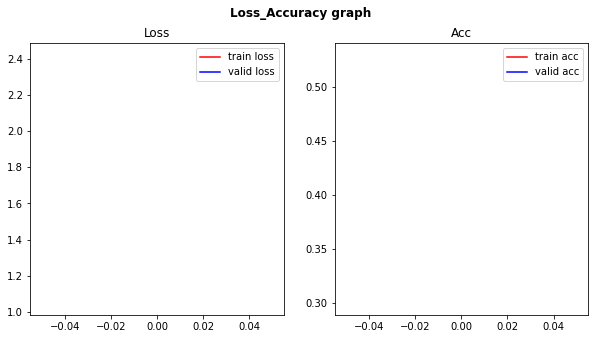

Start Train Epoch 1
Iter: 10/363, train epoch loss: 0.796873, train epoch acc: 0.632812, time: 22.920548
Iter: 20/363, train epoch loss: 0.807543, train epoch acc: 0.636719, time: 17.455847
Iter: 30/363, train epoch loss: 0.813411, train epoch acc: 0.631771, time: 19.537677
Iter: 40/363, train epoch loss: 0.805231, train epoch acc: 0.639453, time: 21.180229
Iter: 50/363, train epoch loss: 0.812015, train epoch acc: 0.643125, time: 20.718044
Iter: 60/363, train epoch loss: 0.817622, train epoch acc: 0.643750, time: 19.946746
Iter: 70/363, train epoch loss: 0.810787, train epoch acc: 0.650670, time: 17.865754
Iter: 80/363, train epoch loss: 0.811033, train epoch acc: 0.650586, time: 19.823101
Iter: 90/363, train epoch loss: 0.814380, train epoch acc: 0.648438, time: 20.137252
Iter: 100/363, train epoch loss: 0.818699, train epoch acc: 0.648906, time: 17.082441
Iter: 110/363, train epoch loss: 0.812092, train epoch acc: 0.651847, time: 20.151517
Iter: 120/363, train epoch loss: 0.811581, 

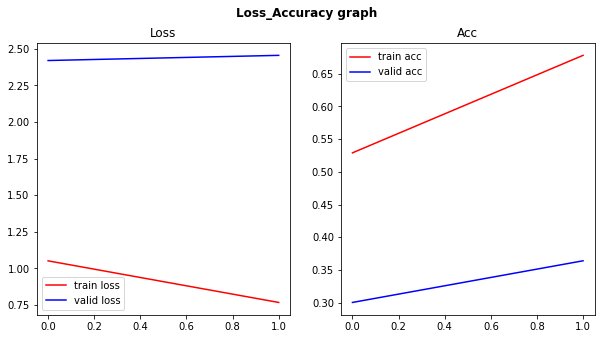

Start Train Epoch 2
Iter: 10/363, train epoch loss: 0.678704, train epoch acc: 0.720313, time: 18.459592
Iter: 20/363, train epoch loss: 0.686988, train epoch acc: 0.718750, time: 18.683608
Iter: 30/363, train epoch loss: 0.661235, train epoch acc: 0.736458, time: 17.656568
Iter: 40/363, train epoch loss: 0.676380, train epoch acc: 0.732422, time: 16.292807
Iter: 50/363, train epoch loss: 0.679522, train epoch acc: 0.728750, time: 17.323782
Iter: 60/363, train epoch loss: 0.684029, train epoch acc: 0.727083, time: 15.928832
Iter: 70/363, train epoch loss: 0.679738, train epoch acc: 0.731027, time: 17.697278
Iter: 80/363, train epoch loss: 0.675436, train epoch acc: 0.730078, time: 15.935418
Iter: 90/363, train epoch loss: 0.674504, train epoch acc: 0.729340, time: 15.109561
Iter: 100/363, train epoch loss: 0.674256, train epoch acc: 0.727344, time: 17.450550
Iter: 110/363, train epoch loss: 0.668148, train epoch acc: 0.730682, time: 16.776566
Iter: 120/363, train epoch loss: 0.663617, 

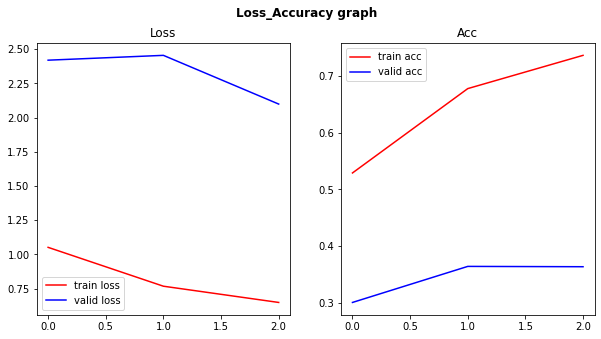

Start Train Epoch 3
Iter: 10/363, train epoch loss: 0.593312, train epoch acc: 0.757812, time: 17.689557
Iter: 20/363, train epoch loss: 0.614051, train epoch acc: 0.747656, time: 18.089819
Iter: 30/363, train epoch loss: 0.627645, train epoch acc: 0.746354, time: 15.578519
Iter: 40/363, train epoch loss: 0.618628, train epoch acc: 0.747656, time: 16.022418
Iter: 50/363, train epoch loss: 0.610040, train epoch acc: 0.751875, time: 16.675360
Iter: 60/363, train epoch loss: 0.616575, train epoch acc: 0.748958, time: 18.506819
Iter: 70/363, train epoch loss: 0.611989, train epoch acc: 0.751563, time: 17.021397
Iter: 80/363, train epoch loss: 0.609371, train epoch acc: 0.752930, time: 16.799962
Iter: 90/363, train epoch loss: 0.606871, train epoch acc: 0.752778, time: 17.478300
Iter: 100/363, train epoch loss: 0.606751, train epoch acc: 0.753750, time: 18.867880
Iter: 110/363, train epoch loss: 0.605183, train epoch acc: 0.753267, time: 16.326439
Iter: 120/363, train epoch loss: 0.607012, 

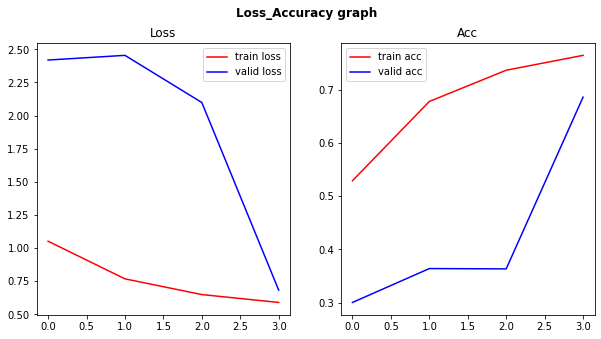

Start Train Epoch 4
Iter: 10/363, train epoch loss: 0.565648, train epoch acc: 0.775000, time: 17.557600
Iter: 20/363, train epoch loss: 0.564891, train epoch acc: 0.772656, time: 15.354210
Iter: 30/363, train epoch loss: 0.547605, train epoch acc: 0.773438, time: 15.088453
Iter: 40/363, train epoch loss: 0.540809, train epoch acc: 0.779297, time: 15.186302
Iter: 50/363, train epoch loss: 0.542121, train epoch acc: 0.779375, time: 15.134495
Iter: 60/363, train epoch loss: 0.549800, train epoch acc: 0.776302, time: 15.107532
Iter: 70/363, train epoch loss: 0.550151, train epoch acc: 0.776786, time: 15.089122
Iter: 80/363, train epoch loss: 0.556006, train epoch acc: 0.775977, time: 15.340103
Iter: 90/363, train epoch loss: 0.565450, train epoch acc: 0.773090, time: 15.234920
Iter: 100/363, train epoch loss: 0.567744, train epoch acc: 0.771563, time: 15.023509
Iter: 110/363, train epoch loss: 0.568050, train epoch acc: 0.772585, time: 15.606950
Iter: 120/363, train epoch loss: 0.564778, 

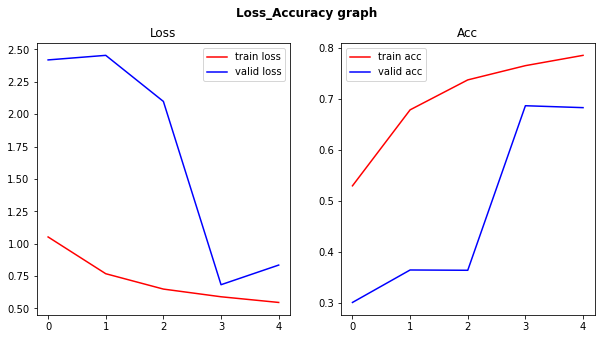

Start Train Epoch 5
Iter: 10/363, train epoch loss: 0.514611, train epoch acc: 0.798438, time: 17.256791
Iter: 20/363, train epoch loss: 0.534734, train epoch acc: 0.789062, time: 15.130772
Iter: 30/363, train epoch loss: 0.523030, train epoch acc: 0.792188, time: 15.094014
Iter: 40/363, train epoch loss: 0.517422, train epoch acc: 0.796484, time: 15.186811
Iter: 50/363, train epoch loss: 0.514917, train epoch acc: 0.798125, time: 15.119605
Iter: 60/363, train epoch loss: 0.517447, train epoch acc: 0.796615, time: 15.063075
Iter: 70/363, train epoch loss: 0.511606, train epoch acc: 0.799777, time: 16.575279
Iter: 80/363, train epoch loss: 0.508877, train epoch acc: 0.800000, time: 15.434401
Iter: 90/363, train epoch loss: 0.509120, train epoch acc: 0.798438, time: 15.102099
Iter: 100/363, train epoch loss: 0.512415, train epoch acc: 0.797656, time: 14.947315
Iter: 110/363, train epoch loss: 0.509262, train epoch acc: 0.799574, time: 14.867428
Iter: 120/363, train epoch loss: 0.508653, 

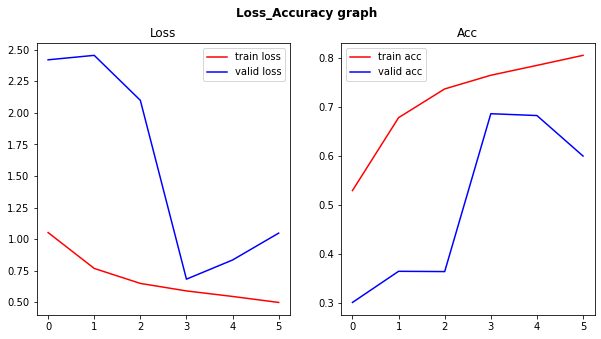

Start Train Epoch 6
Iter: 10/363, train epoch loss: 0.460624, train epoch acc: 0.815625, time: 16.834797
Iter: 20/363, train epoch loss: 0.469475, train epoch acc: 0.820312, time: 15.619470
Iter: 30/363, train epoch loss: 0.470603, train epoch acc: 0.811979, time: 15.093913
Iter: 40/363, train epoch loss: 0.470719, train epoch acc: 0.814063, time: 15.093264
Iter: 50/363, train epoch loss: 0.473817, train epoch acc: 0.817500, time: 15.132283
Iter: 60/363, train epoch loss: 0.480337, train epoch acc: 0.814583, time: 15.483540
Iter: 70/363, train epoch loss: 0.485758, train epoch acc: 0.812054, time: 15.360048
Iter: 80/363, train epoch loss: 0.493569, train epoch acc: 0.809375, time: 14.997384
Iter: 90/363, train epoch loss: 0.489833, train epoch acc: 0.812326, time: 15.044832
Iter: 100/363, train epoch loss: 0.489226, train epoch acc: 0.813281, time: 15.071148
Iter: 110/363, train epoch loss: 0.487190, train epoch acc: 0.812784, time: 15.017054
Iter: 120/363, train epoch loss: 0.486656, 

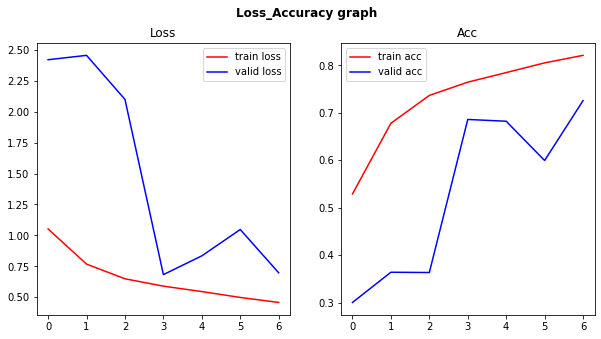

Start Train Epoch 7
Iter: 10/363, train epoch loss: 0.431103, train epoch acc: 0.823438, time: 16.951171
Iter: 20/363, train epoch loss: 0.415370, train epoch acc: 0.839063, time: 17.229816
Iter: 30/363, train epoch loss: 0.423106, train epoch acc: 0.841146, time: 16.387158
Iter: 40/363, train epoch loss: 0.434918, train epoch acc: 0.837109, time: 15.302063
Iter: 50/363, train epoch loss: 0.430602, train epoch acc: 0.838750, time: 15.288980
Iter: 60/363, train epoch loss: 0.433525, train epoch acc: 0.836979, time: 16.045161
Iter: 70/363, train epoch loss: 0.432518, train epoch acc: 0.836161, time: 16.431105
Iter: 80/363, train epoch loss: 0.432866, train epoch acc: 0.835547, time: 15.213016
Iter: 90/363, train epoch loss: 0.430139, train epoch acc: 0.836632, time: 16.099242
Iter: 100/363, train epoch loss: 0.428107, train epoch acc: 0.835938, time: 15.427685
Iter: 110/363, train epoch loss: 0.426375, train epoch acc: 0.836648, time: 15.200349
Iter: 120/363, train epoch loss: 0.423459, 

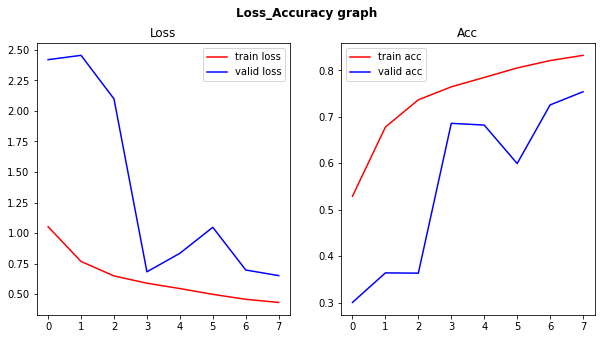

Start Train Epoch 8
Iter: 10/363, train epoch loss: 0.427542, train epoch acc: 0.832812, time: 16.845888
Iter: 20/363, train epoch loss: 0.398497, train epoch acc: 0.845313, time: 16.235848
Iter: 30/363, train epoch loss: 0.392795, train epoch acc: 0.850521, time: 15.996315
Iter: 40/363, train epoch loss: 0.386852, train epoch acc: 0.856641, time: 16.710688
Iter: 50/363, train epoch loss: 0.388951, train epoch acc: 0.853437, time: 15.061987
Iter: 60/363, train epoch loss: 0.387591, train epoch acc: 0.851562, time: 15.026899
Iter: 70/363, train epoch loss: 0.386231, train epoch acc: 0.854241, time: 15.181982
Iter: 80/363, train epoch loss: 0.391130, train epoch acc: 0.850781, time: 15.025715
Iter: 90/363, train epoch loss: 0.391932, train epoch acc: 0.848785, time: 14.981038
Iter: 100/363, train epoch loss: 0.393598, train epoch acc: 0.849063, time: 15.871656
Iter: 110/363, train epoch loss: 0.392062, train epoch acc: 0.849716, time: 16.614788
Iter: 120/363, train epoch loss: 0.389500, 

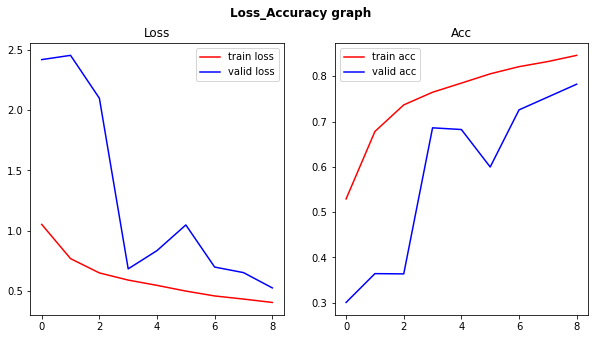

Start Train Epoch 9
Iter: 10/363, train epoch loss: 0.400501, train epoch acc: 0.857812, time: 16.631469
Iter: 20/363, train epoch loss: 0.399071, train epoch acc: 0.854688, time: 15.332135
Iter: 30/363, train epoch loss: 0.396217, train epoch acc: 0.849479, time: 15.132818
Iter: 40/363, train epoch loss: 0.389321, train epoch acc: 0.853516, time: 15.182113
Iter: 50/363, train epoch loss: 0.384020, train epoch acc: 0.855313, time: 15.418410
Iter: 60/363, train epoch loss: 0.380505, train epoch acc: 0.855729, time: 15.146842
Iter: 70/363, train epoch loss: 0.379092, train epoch acc: 0.856473, time: 15.010924
Iter: 80/363, train epoch loss: 0.387902, train epoch acc: 0.850781, time: 15.079117
Iter: 90/363, train epoch loss: 0.384607, train epoch acc: 0.853646, time: 15.102792
Iter: 100/363, train epoch loss: 0.382441, train epoch acc: 0.854375, time: 14.953845
Iter: 110/363, train epoch loss: 0.382851, train epoch acc: 0.855114, time: 15.951617
Iter: 120/363, train epoch loss: 0.385188, 

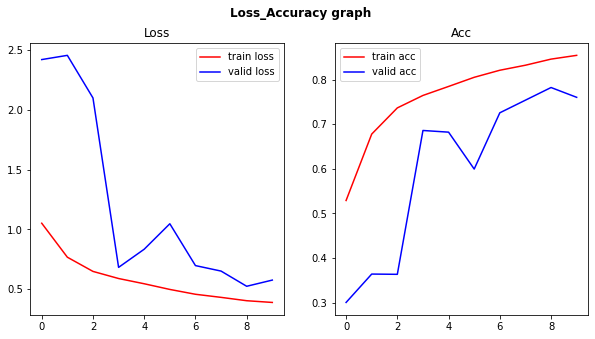

Start Train Epoch 10
Iter: 10/363, train epoch loss: 0.415282, train epoch acc: 0.835938, time: 16.688942
Iter: 20/363, train epoch loss: 0.396048, train epoch acc: 0.843750, time: 15.897701
Iter: 30/363, train epoch loss: 0.410286, train epoch acc: 0.842187, time: 15.704722
Iter: 40/363, train epoch loss: 0.397508, train epoch acc: 0.851953, time: 16.574841
Iter: 50/363, train epoch loss: 0.387828, train epoch acc: 0.856875, time: 15.396423
Iter: 60/363, train epoch loss: 0.384371, train epoch acc: 0.855208, time: 15.324452
Iter: 70/363, train epoch loss: 0.380905, train epoch acc: 0.855804, time: 15.359166
Iter: 80/363, train epoch loss: 0.380767, train epoch acc: 0.855078, time: 16.217473
Iter: 90/363, train epoch loss: 0.383820, train epoch acc: 0.854514, time: 17.150524
Iter: 100/363, train epoch loss: 0.386365, train epoch acc: 0.853437, time: 16.888776
Iter: 110/363, train epoch loss: 0.383386, train epoch acc: 0.854830, time: 17.008647
Iter: 120/363, train epoch loss: 0.384080,

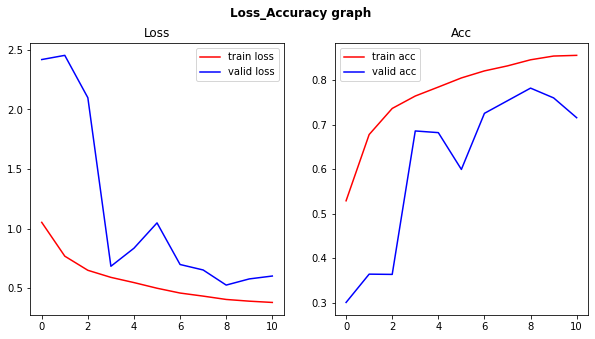

Start Train Epoch 11
Iter: 10/363, train epoch loss: 0.371237, train epoch acc: 0.848437, time: 16.706256
Iter: 20/363, train epoch loss: 0.341409, train epoch acc: 0.864844, time: 15.674987
Iter: 30/363, train epoch loss: 0.355559, train epoch acc: 0.860417, time: 15.781321
Iter: 40/363, train epoch loss: 0.353222, train epoch acc: 0.865234, time: 15.695596
Iter: 50/363, train epoch loss: 0.348737, train epoch acc: 0.869062, time: 15.213982
Iter: 60/363, train epoch loss: 0.355396, train epoch acc: 0.867969, time: 15.135121
Iter: 70/363, train epoch loss: 0.354951, train epoch acc: 0.866964, time: 15.148838
Iter: 80/363, train epoch loss: 0.355008, train epoch acc: 0.867383, time: 15.208211
Iter: 90/363, train epoch loss: 0.354366, train epoch acc: 0.866667, time: 15.233095
Iter: 100/363, train epoch loss: 0.354442, train epoch acc: 0.867812, time: 18.889972
Iter: 110/363, train epoch loss: 0.355135, train epoch acc: 0.867614, time: 15.370835
Iter: 120/363, train epoch loss: 0.355458,

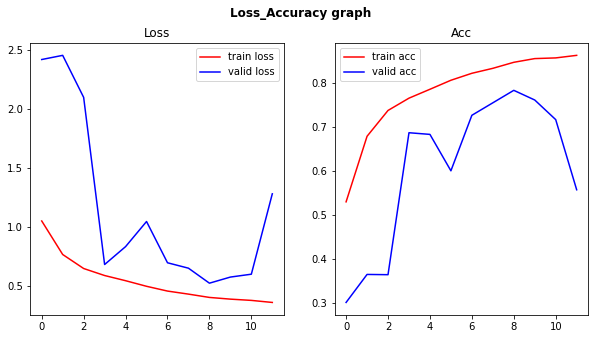

Start Train Epoch 12
Iter: 10/363, train epoch loss: 0.359147, train epoch acc: 0.876563, time: 19.857001
Iter: 20/363, train epoch loss: 0.358372, train epoch acc: 0.870313, time: 17.008392
Iter: 30/363, train epoch loss: 0.350418, train epoch acc: 0.872917, time: 15.390503
Iter: 40/363, train epoch loss: 0.356184, train epoch acc: 0.871484, time: 15.168103
Iter: 50/363, train epoch loss: 0.358868, train epoch acc: 0.869062, time: 15.344235
Iter: 60/363, train epoch loss: 0.358668, train epoch acc: 0.868490, time: 15.115616
Iter: 70/363, train epoch loss: 0.354844, train epoch acc: 0.870536, time: 15.683817
Iter: 80/363, train epoch loss: 0.352319, train epoch acc: 0.870703, time: 17.828409
Iter: 90/363, train epoch loss: 0.351808, train epoch acc: 0.870833, time: 16.107732
Iter: 100/363, train epoch loss: 0.348699, train epoch acc: 0.872656, time: 15.446731
Iter: 110/363, train epoch loss: 0.350905, train epoch acc: 0.872159, time: 15.196651
Iter: 120/363, train epoch loss: 0.351960,

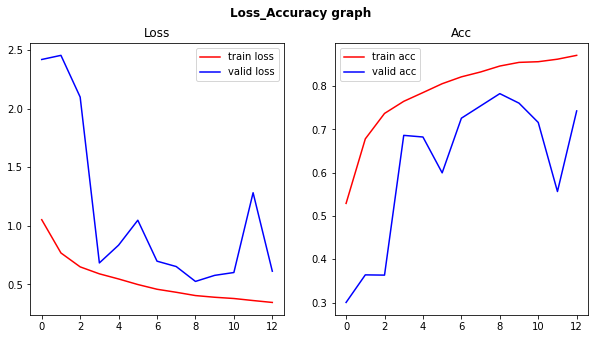

Start Train Epoch 13
Iter: 10/363, train epoch loss: 0.354875, train epoch acc: 0.854688, time: 17.609771
Iter: 20/363, train epoch loss: 0.367312, train epoch acc: 0.857812, time: 16.524442
Iter: 30/363, train epoch loss: 0.373281, train epoch acc: 0.859896, time: 15.522319
Iter: 40/363, train epoch loss: 0.369651, train epoch acc: 0.861328, time: 15.358575
Iter: 50/363, train epoch loss: 0.373159, train epoch acc: 0.860313, time: 15.309701
Iter: 60/363, train epoch loss: 0.366702, train epoch acc: 0.860677, time: 17.611522
Iter: 70/363, train epoch loss: 0.363636, train epoch acc: 0.861161, time: 16.483350
Iter: 80/363, train epoch loss: 0.364231, train epoch acc: 0.862305, time: 16.301663
Iter: 90/363, train epoch loss: 0.364704, train epoch acc: 0.863194, time: 15.820302
Iter: 100/363, train epoch loss: 0.361903, train epoch acc: 0.864531, time: 15.346636
Iter: 110/363, train epoch loss: 0.361486, train epoch acc: 0.863920, time: 15.145162
Iter: 120/363, train epoch loss: 0.358396,

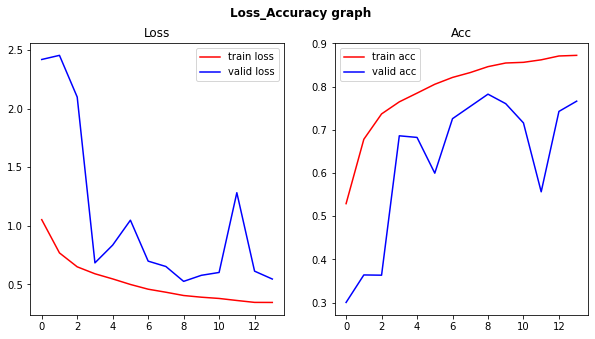

Start Train Epoch 14
Iter: 10/363, train epoch loss: 0.333975, train epoch acc: 0.889062, time: 15.952408
Iter: 20/363, train epoch loss: 0.329730, train epoch acc: 0.886719, time: 16.415724
Iter: 30/363, train epoch loss: 0.320251, train epoch acc: 0.889583, time: 17.540780
Iter: 40/363, train epoch loss: 0.311128, train epoch acc: 0.893750, time: 16.270607
Iter: 50/363, train epoch loss: 0.310445, train epoch acc: 0.893437, time: 15.702479
Iter: 60/363, train epoch loss: 0.319745, train epoch acc: 0.888021, time: 15.709035
Iter: 70/363, train epoch loss: 0.319537, train epoch acc: 0.889062, time: 16.158676
Iter: 80/363, train epoch loss: 0.317093, train epoch acc: 0.887891, time: 16.325487
Iter: 90/363, train epoch loss: 0.317369, train epoch acc: 0.885764, time: 16.361057
Iter: 100/363, train epoch loss: 0.316603, train epoch acc: 0.886563, time: 15.169188
Iter: 110/363, train epoch loss: 0.320170, train epoch acc: 0.884801, time: 15.087903
Iter: 120/363, train epoch loss: 0.324462,

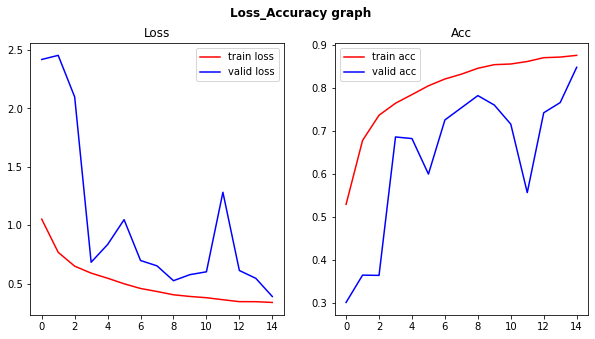

Start Train Epoch 15
Iter: 10/363, train epoch loss: 0.326292, train epoch acc: 0.884375, time: 16.299443
Iter: 20/363, train epoch loss: 0.352802, train epoch acc: 0.869531, time: 16.586967
Iter: 30/363, train epoch loss: 0.342841, train epoch acc: 0.873437, time: 17.898376
Iter: 40/363, train epoch loss: 0.341474, train epoch acc: 0.873828, time: 17.375809
Iter: 50/363, train epoch loss: 0.344776, train epoch acc: 0.870000, time: 17.703445
Iter: 60/363, train epoch loss: 0.350987, train epoch acc: 0.867969, time: 17.781499
Iter: 70/363, train epoch loss: 0.348296, train epoch acc: 0.867411, time: 16.749444
Iter: 80/363, train epoch loss: 0.345391, train epoch acc: 0.867578, time: 15.134221
Iter: 90/363, train epoch loss: 0.343509, train epoch acc: 0.868750, time: 15.233577
Iter: 100/363, train epoch loss: 0.341806, train epoch acc: 0.870781, time: 16.255131
Iter: 110/363, train epoch loss: 0.339772, train epoch acc: 0.872727, time: 15.592867
Iter: 120/363, train epoch loss: 0.339382,

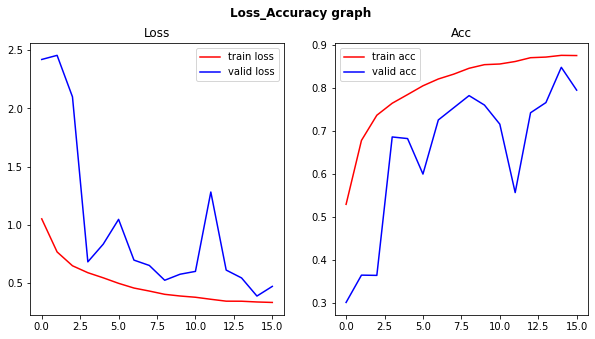

Start Train Epoch 16
Iter: 10/363, train epoch loss: 0.341429, train epoch acc: 0.876563, time: 17.460280
Iter: 20/363, train epoch loss: 0.334610, train epoch acc: 0.878906, time: 19.050190
Iter: 30/363, train epoch loss: 0.333006, train epoch acc: 0.875000, time: 16.986583
Iter: 40/363, train epoch loss: 0.344484, train epoch acc: 0.867188, time: 15.853403
Iter: 50/363, train epoch loss: 0.344119, train epoch acc: 0.870000, time: 15.755800
Iter: 60/363, train epoch loss: 0.344582, train epoch acc: 0.870573, time: 15.174699
Iter: 70/363, train epoch loss: 0.342024, train epoch acc: 0.868750, time: 15.355902
Iter: 80/363, train epoch loss: 0.336802, train epoch acc: 0.872461, time: 15.270386
Iter: 90/363, train epoch loss: 0.333091, train epoch acc: 0.873958, time: 15.174921
Iter: 100/363, train epoch loss: 0.331763, train epoch acc: 0.875469, time: 15.382647
Iter: 110/363, train epoch loss: 0.332270, train epoch acc: 0.875284, time: 15.301597
Iter: 120/363, train epoch loss: 0.331106,

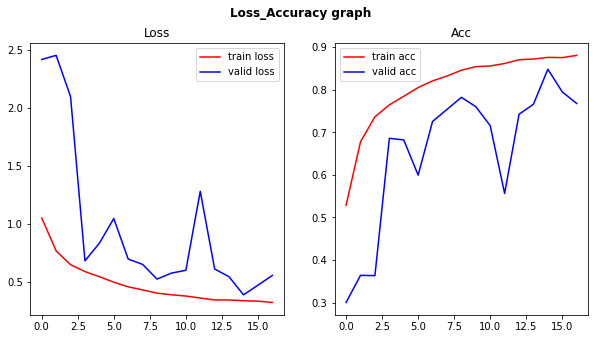

Start Train Epoch 17
Iter: 10/363, train epoch loss: 0.359578, train epoch acc: 0.865625, time: 18.878512
Iter: 20/363, train epoch loss: 0.346593, train epoch acc: 0.867969, time: 16.336510
Iter: 30/363, train epoch loss: 0.362693, train epoch acc: 0.860938, time: 17.445252
Iter: 40/363, train epoch loss: 0.357952, train epoch acc: 0.864062, time: 17.317497
Iter: 50/363, train epoch loss: 0.364754, train epoch acc: 0.860625, time: 17.394202
Iter: 60/363, train epoch loss: 0.355771, train epoch acc: 0.863802, time: 16.361524
Iter: 70/363, train epoch loss: 0.347267, train epoch acc: 0.867634, time: 15.840607
Iter: 80/363, train epoch loss: 0.343205, train epoch acc: 0.870508, time: 20.178420
Iter: 90/363, train epoch loss: 0.341003, train epoch acc: 0.872743, time: 16.849868
Iter: 100/363, train epoch loss: 0.337923, train epoch acc: 0.875313, time: 17.706682
Iter: 110/363, train epoch loss: 0.337969, train epoch acc: 0.876705, time: 17.828379
Iter: 120/363, train epoch loss: 0.335585,

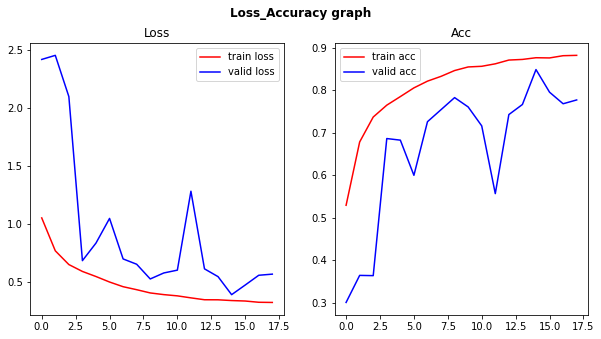

Start Train Epoch 18
Iter: 10/363, train epoch loss: 0.306805, train epoch acc: 0.887500, time: 16.761658
Iter: 20/363, train epoch loss: 0.321517, train epoch acc: 0.884375, time: 15.280119
Iter: 30/363, train epoch loss: 0.314922, train epoch acc: 0.890104, time: 17.764312
Iter: 40/363, train epoch loss: 0.306786, train epoch acc: 0.893750, time: 16.400617
Iter: 50/363, train epoch loss: 0.311206, train epoch acc: 0.891563, time: 15.165353
Iter: 60/363, train epoch loss: 0.316793, train epoch acc: 0.885677, time: 15.150983
Iter: 70/363, train epoch loss: 0.321251, train epoch acc: 0.883705, time: 16.231998
Iter: 80/363, train epoch loss: 0.319847, train epoch acc: 0.882812, time: 14.970526
Iter: 90/363, train epoch loss: 0.319855, train epoch acc: 0.882639, time: 15.021708
Iter: 100/363, train epoch loss: 0.318839, train epoch acc: 0.884531, time: 14.953079
Iter: 110/363, train epoch loss: 0.320107, train epoch acc: 0.884659, time: 15.090369
Iter: 120/363, train epoch loss: 0.319762,

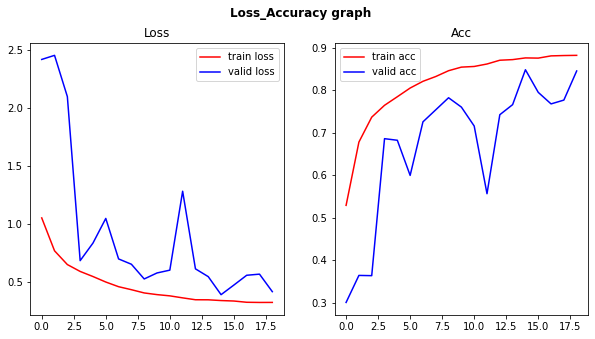

Start Train Epoch 19
Iter: 10/363, train epoch loss: 0.275690, train epoch acc: 0.912500, time: 17.006388
Iter: 20/363, train epoch loss: 0.312786, train epoch acc: 0.891406, time: 17.385185
Iter: 30/363, train epoch loss: 0.315364, train epoch acc: 0.888021, time: 15.963380
Iter: 40/363, train epoch loss: 0.320346, train epoch acc: 0.885156, time: 16.079638
Iter: 50/363, train epoch loss: 0.316773, train epoch acc: 0.885625, time: 17.587035
Iter: 60/363, train epoch loss: 0.310326, train epoch acc: 0.887760, time: 17.518974
Iter: 70/363, train epoch loss: 0.308825, train epoch acc: 0.889062, time: 15.844134
Iter: 80/363, train epoch loss: 0.311864, train epoch acc: 0.888477, time: 15.246065
Iter: 90/363, train epoch loss: 0.311978, train epoch acc: 0.887847, time: 15.229676
Iter: 100/363, train epoch loss: 0.313325, train epoch acc: 0.886719, time: 15.205604
Iter: 110/363, train epoch loss: 0.317153, train epoch acc: 0.884091, time: 15.225262
Iter: 120/363, train epoch loss: 0.314965,

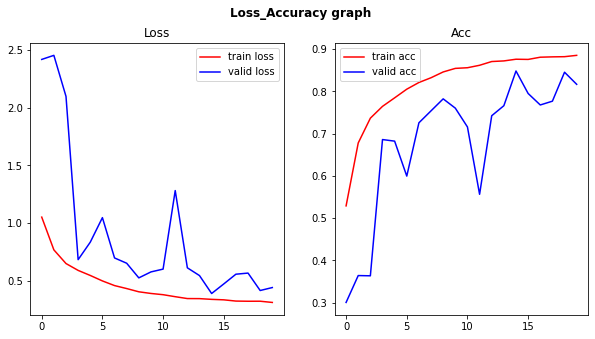

Start Train Epoch 20
Iter: 10/363, train epoch loss: 0.343191, train epoch acc: 0.867188, time: 16.862662
Iter: 20/363, train epoch loss: 0.340101, train epoch acc: 0.875000, time: 15.136634
Iter: 30/363, train epoch loss: 0.334886, train epoch acc: 0.873958, time: 16.155668
Iter: 40/363, train epoch loss: 0.330564, train epoch acc: 0.878906, time: 15.739494
Iter: 50/363, train epoch loss: 0.323290, train epoch acc: 0.880000, time: 16.951267
Iter: 60/363, train epoch loss: 0.322755, train epoch acc: 0.880469, time: 15.447583
Iter: 70/363, train epoch loss: 0.317409, train epoch acc: 0.883705, time: 15.130341
Iter: 80/363, train epoch loss: 0.318779, train epoch acc: 0.883398, time: 15.146379
Iter: 90/363, train epoch loss: 0.318982, train epoch acc: 0.883333, time: 16.076430
Iter: 100/363, train epoch loss: 0.322886, train epoch acc: 0.883281, time: 19.605189
Iter: 110/363, train epoch loss: 0.322343, train epoch acc: 0.882812, time: 16.161927
Iter: 120/363, train epoch loss: 0.318508,

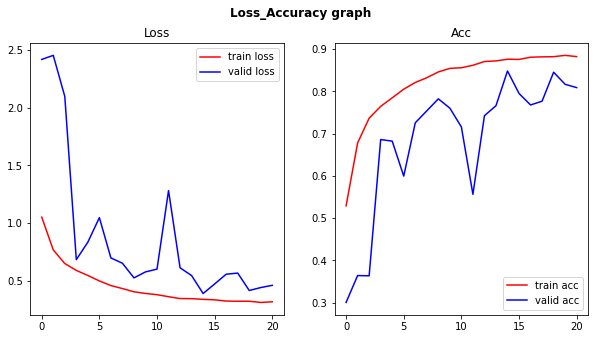

Start Train Epoch 21
Iter: 10/363, train epoch loss: 0.253965, train epoch acc: 0.926562, time: 16.436092
Iter: 20/363, train epoch loss: 0.262093, train epoch acc: 0.917188, time: 15.356629
Iter: 30/363, train epoch loss: 0.276528, train epoch acc: 0.910937, time: 15.614056
Iter: 40/363, train epoch loss: 0.284600, train epoch acc: 0.904687, time: 16.086402
Iter: 50/363, train epoch loss: 0.284766, train epoch acc: 0.903438, time: 15.781378
Iter: 60/363, train epoch loss: 0.287023, train epoch acc: 0.900781, time: 15.060224
Iter: 70/363, train epoch loss: 0.295834, train epoch acc: 0.894866, time: 15.975887
Iter: 80/363, train epoch loss: 0.296636, train epoch acc: 0.892773, time: 15.845290
Iter: 90/363, train epoch loss: 0.295554, train epoch acc: 0.893403, time: 15.327786
Iter: 100/363, train epoch loss: 0.293827, train epoch acc: 0.893750, time: 15.020752
Iter: 110/363, train epoch loss: 0.295410, train epoch acc: 0.894886, time: 15.010399
Iter: 120/363, train epoch loss: 0.296650,

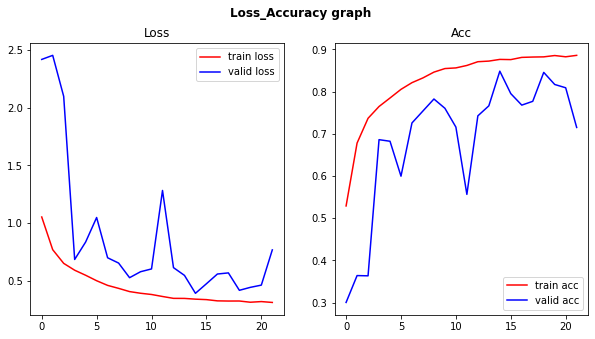

Start Train Epoch 22
Iter: 10/363, train epoch loss: 0.280466, train epoch acc: 0.884375, time: 16.537214
Iter: 20/363, train epoch loss: 0.292364, train epoch acc: 0.889062, time: 15.175441
Iter: 30/363, train epoch loss: 0.312574, train epoch acc: 0.881250, time: 15.925501
Iter: 40/363, train epoch loss: 0.311429, train epoch acc: 0.880078, time: 15.148534
Iter: 50/363, train epoch loss: 0.304742, train epoch acc: 0.884375, time: 15.233382
Iter: 60/363, train epoch loss: 0.309881, train epoch acc: 0.882292, time: 16.467020
Iter: 70/363, train epoch loss: 0.308044, train epoch acc: 0.882812, time: 15.176307
Iter: 80/363, train epoch loss: 0.310004, train epoch acc: 0.882812, time: 15.149961
Iter: 90/363, train epoch loss: 0.309850, train epoch acc: 0.882812, time: 15.070130
Iter: 100/363, train epoch loss: 0.308724, train epoch acc: 0.885625, time: 15.635895
Iter: 110/363, train epoch loss: 0.307930, train epoch acc: 0.887642, time: 16.252474
Iter: 120/363, train epoch loss: 0.313204,

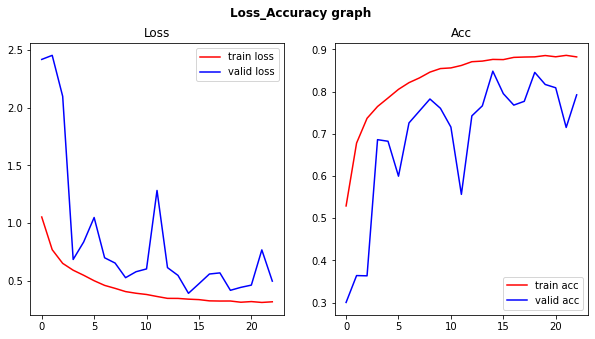

Start Train Epoch 23
Iter: 10/363, train epoch loss: 0.297319, train epoch acc: 0.892188, time: 17.371804
Iter: 20/363, train epoch loss: 0.304338, train epoch acc: 0.886719, time: 15.819123
Iter: 30/363, train epoch loss: 0.303293, train epoch acc: 0.885417, time: 15.540795
Iter: 40/363, train epoch loss: 0.298414, train epoch acc: 0.888672, time: 15.751402
Iter: 50/363, train epoch loss: 0.290458, train epoch acc: 0.891875, time: 16.049031
Iter: 60/363, train epoch loss: 0.292385, train epoch acc: 0.892188, time: 15.398480
Iter: 70/363, train epoch loss: 0.295791, train epoch acc: 0.890402, time: 15.458994
Iter: 80/363, train epoch loss: 0.298621, train epoch acc: 0.889062, time: 15.125832
Iter: 90/363, train epoch loss: 0.294155, train epoch acc: 0.890799, time: 15.791327
Iter: 100/363, train epoch loss: 0.294602, train epoch acc: 0.891094, time: 16.982648
Iter: 110/363, train epoch loss: 0.296548, train epoch acc: 0.890483, time: 15.934008
Iter: 120/363, train epoch loss: 0.295341,

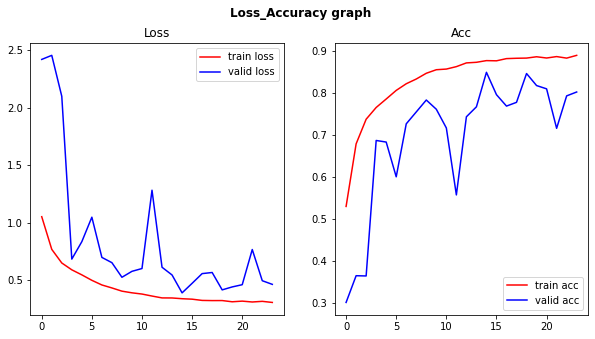

Start Train Epoch 24
Iter: 10/363, train epoch loss: 0.257242, train epoch acc: 0.912500, time: 16.142193
Iter: 20/363, train epoch loss: 0.270703, train epoch acc: 0.904687, time: 15.173058
Iter: 30/363, train epoch loss: 0.279574, train epoch acc: 0.899479, time: 15.155160
Iter: 40/363, train epoch loss: 0.288792, train epoch acc: 0.893359, time: 15.663959
Iter: 50/363, train epoch loss: 0.291176, train epoch acc: 0.890938, time: 15.216280
Iter: 60/363, train epoch loss: 0.291897, train epoch acc: 0.890885, time: 15.126095
Iter: 70/363, train epoch loss: 0.289866, train epoch acc: 0.892634, time: 15.123473
Iter: 80/363, train epoch loss: 0.285418, train epoch acc: 0.895312, time: 15.127114
Iter: 90/363, train epoch loss: 0.285449, train epoch acc: 0.894618, time: 15.929098
Iter: 100/363, train epoch loss: 0.289606, train epoch acc: 0.892188, time: 15.167268
Iter: 110/363, train epoch loss: 0.288803, train epoch acc: 0.892898, time: 15.100287
Iter: 120/363, train epoch loss: 0.287078,

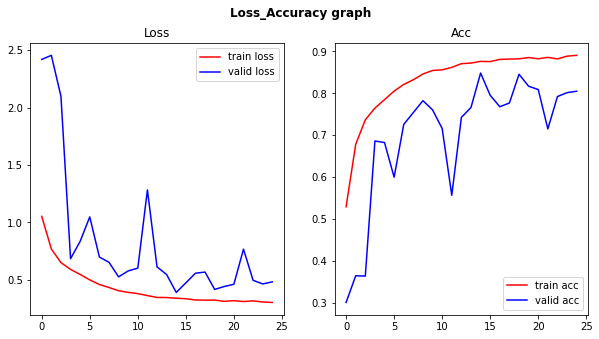

Start Train Epoch 25
Iter: 10/363, train epoch loss: 0.267172, train epoch acc: 0.889062, time: 16.969608
Iter: 20/363, train epoch loss: 0.283578, train epoch acc: 0.891406, time: 15.025704
Iter: 30/363, train epoch loss: 0.278202, train epoch acc: 0.896354, time: 15.836306
Iter: 40/363, train epoch loss: 0.283710, train epoch acc: 0.891016, time: 15.421060
Iter: 50/363, train epoch loss: 0.281938, train epoch acc: 0.893125, time: 15.193590
Iter: 60/363, train epoch loss: 0.281831, train epoch acc: 0.893750, time: 16.707069
Iter: 70/363, train epoch loss: 0.285523, train epoch acc: 0.892411, time: 15.077429
Iter: 80/363, train epoch loss: 0.290212, train epoch acc: 0.890234, time: 17.101862
Iter: 90/363, train epoch loss: 0.292547, train epoch acc: 0.891319, time: 15.493216
Iter: 100/363, train epoch loss: 0.295030, train epoch acc: 0.890312, time: 15.454904
Iter: 110/363, train epoch loss: 0.292962, train epoch acc: 0.892472, time: 16.285309
Iter: 120/363, train epoch loss: 0.293680,

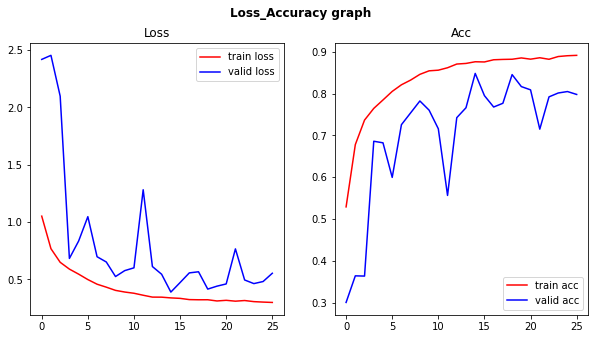

Start Train Epoch 26
Iter: 10/363, train epoch loss: 0.312854, train epoch acc: 0.878125, time: 18.038562
Iter: 20/363, train epoch loss: 0.302546, train epoch acc: 0.889062, time: 16.700151
Iter: 30/363, train epoch loss: 0.317091, train epoch acc: 0.886979, time: 15.958474
Iter: 40/363, train epoch loss: 0.320053, train epoch acc: 0.885938, time: 17.294534
Iter: 50/363, train epoch loss: 0.313107, train epoch acc: 0.887813, time: 18.794648
Iter: 60/363, train epoch loss: 0.308043, train epoch acc: 0.888802, time: 16.998562
Iter: 70/363, train epoch loss: 0.298191, train epoch acc: 0.892857, time: 17.387949
Iter: 80/363, train epoch loss: 0.292360, train epoch acc: 0.894141, time: 17.802457
Iter: 90/363, train epoch loss: 0.285095, train epoch acc: 0.895486, time: 16.508163
Iter: 100/363, train epoch loss: 0.286739, train epoch acc: 0.892969, time: 17.528869
Iter: 110/363, train epoch loss: 0.286740, train epoch acc: 0.892614, time: 16.677335
Iter: 120/363, train epoch loss: 0.285375,

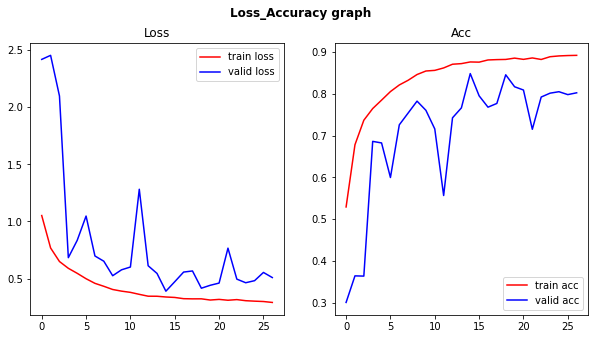

Start Train Epoch 27
Iter: 10/363, train epoch loss: 0.292681, train epoch acc: 0.898438, time: 17.173128
Iter: 20/363, train epoch loss: 0.269217, train epoch acc: 0.903125, time: 17.169567
Iter: 30/363, train epoch loss: 0.271995, train epoch acc: 0.903125, time: 16.326718
Iter: 40/363, train epoch loss: 0.274423, train epoch acc: 0.903906, time: 17.826978
Iter: 50/363, train epoch loss: 0.284235, train epoch acc: 0.897813, time: 16.647289
Iter: 60/363, train epoch loss: 0.285129, train epoch acc: 0.895312, time: 16.099252
Iter: 70/363, train epoch loss: 0.285975, train epoch acc: 0.896429, time: 16.053547
Iter: 80/363, train epoch loss: 0.285800, train epoch acc: 0.897266, time: 15.795659
Iter: 90/363, train epoch loss: 0.285419, train epoch acc: 0.897222, time: 15.602448
Iter: 100/363, train epoch loss: 0.284890, train epoch acc: 0.897656, time: 15.803730
Iter: 110/363, train epoch loss: 0.285973, train epoch acc: 0.898580, time: 18.236486
Iter: 120/363, train epoch loss: 0.288930,

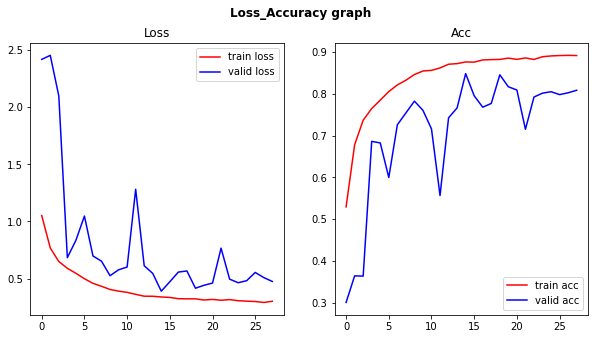

Start Train Epoch 28
Iter: 10/363, train epoch loss: 0.266921, train epoch acc: 0.898438, time: 17.828681
Iter: 20/363, train epoch loss: 0.268928, train epoch acc: 0.899219, time: 16.318263
Iter: 30/363, train epoch loss: 0.274250, train epoch acc: 0.901563, time: 15.882787
Iter: 40/363, train epoch loss: 0.281295, train epoch acc: 0.896484, time: 15.975776
Iter: 50/363, train epoch loss: 0.280997, train epoch acc: 0.897813, time: 15.907545
Iter: 60/363, train epoch loss: 0.285551, train epoch acc: 0.895573, time: 16.060290
Iter: 70/363, train epoch loss: 0.280864, train epoch acc: 0.898214, time: 16.066647
Iter: 80/363, train epoch loss: 0.282641, train epoch acc: 0.898242, time: 15.731290
Iter: 90/363, train epoch loss: 0.286296, train epoch acc: 0.897569, time: 16.207137
Iter: 100/363, train epoch loss: 0.290534, train epoch acc: 0.896250, time: 16.250952
Iter: 110/363, train epoch loss: 0.289766, train epoch acc: 0.895028, time: 16.215141
Iter: 120/363, train epoch loss: 0.288746,

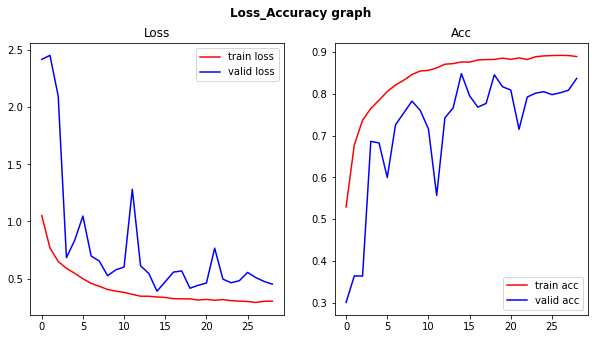

Start Train Epoch 29
Iter: 10/363, train epoch loss: 0.320115, train epoch acc: 0.881250, time: 16.438117
Iter: 20/363, train epoch loss: 0.291817, train epoch acc: 0.890625, time: 16.069984
Iter: 30/363, train epoch loss: 0.295327, train epoch acc: 0.890104, time: 15.897154
Iter: 40/363, train epoch loss: 0.304039, train epoch acc: 0.885938, time: 16.533967
Iter: 50/363, train epoch loss: 0.304981, train epoch acc: 0.886563, time: 15.752069
Iter: 60/363, train epoch loss: 0.295489, train epoch acc: 0.890625, time: 15.881117
Iter: 70/363, train epoch loss: 0.295732, train epoch acc: 0.892411, time: 16.699074
Iter: 80/363, train epoch loss: 0.296415, train epoch acc: 0.890820, time: 16.098619
Iter: 90/363, train epoch loss: 0.299402, train epoch acc: 0.890625, time: 15.938157
Iter: 100/363, train epoch loss: 0.298966, train epoch acc: 0.890312, time: 16.135332
Iter: 110/363, train epoch loss: 0.299310, train epoch acc: 0.890625, time: 15.600244
Iter: 120/363, train epoch loss: 0.296702,

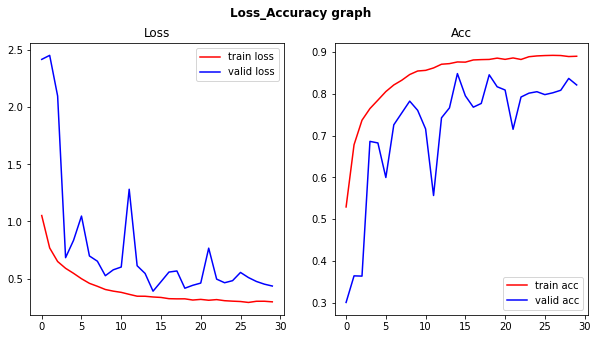

Start Train Epoch 30
Iter: 10/363, train epoch loss: 0.263261, train epoch acc: 0.909375, time: 17.098270
Iter: 20/363, train epoch loss: 0.274295, train epoch acc: 0.905469, time: 18.578079
Iter: 30/363, train epoch loss: 0.270944, train epoch acc: 0.905208, time: 15.979395
Iter: 40/363, train epoch loss: 0.265907, train epoch acc: 0.906250, time: 15.962244
Iter: 50/363, train epoch loss: 0.264905, train epoch acc: 0.908125, time: 16.481913
Iter: 60/363, train epoch loss: 0.268101, train epoch acc: 0.907552, time: 15.730642
Iter: 70/363, train epoch loss: 0.267418, train epoch acc: 0.908929, time: 15.555989
Iter: 80/363, train epoch loss: 0.266171, train epoch acc: 0.910156, time: 16.176561
Iter: 90/363, train epoch loss: 0.266036, train epoch acc: 0.910417, time: 15.628899
Iter: 100/363, train epoch loss: 0.266130, train epoch acc: 0.909219, time: 15.713115
Iter: 110/363, train epoch loss: 0.263860, train epoch acc: 0.909517, time: 15.594282
Iter: 120/363, train epoch loss: 0.264317,

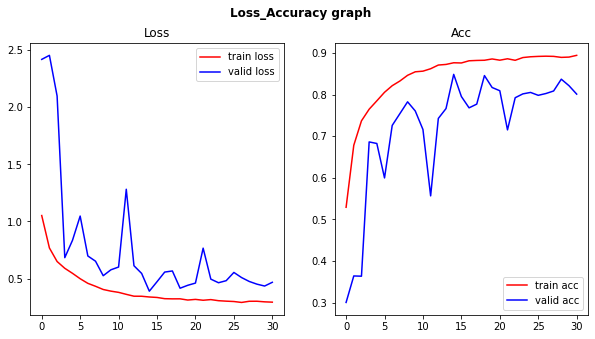

Start Train Epoch 31
Iter: 10/363, train epoch loss: 0.252685, train epoch acc: 0.906250, time: 17.246906
Iter: 20/363, train epoch loss: 0.252777, train epoch acc: 0.910156, time: 16.558389
Iter: 30/363, train epoch loss: 0.259239, train epoch acc: 0.902604, time: 16.622377
Iter: 40/363, train epoch loss: 0.261881, train epoch acc: 0.903906, time: 16.009185
Iter: 50/363, train epoch loss: 0.265716, train epoch acc: 0.904375, time: 15.582194
Iter: 60/363, train epoch loss: 0.269839, train epoch acc: 0.900000, time: 16.006402
Iter: 70/363, train epoch loss: 0.269657, train epoch acc: 0.902455, time: 16.047281
Iter: 80/363, train epoch loss: 0.266431, train epoch acc: 0.903711, time: 17.288837
Iter: 90/363, train epoch loss: 0.268070, train epoch acc: 0.902604, time: 16.610732
Iter: 100/363, train epoch loss: 0.268548, train epoch acc: 0.902344, time: 18.041742
Iter: 110/363, train epoch loss: 0.269542, train epoch acc: 0.901989, time: 16.945196
Iter: 120/363, train epoch loss: 0.267164,

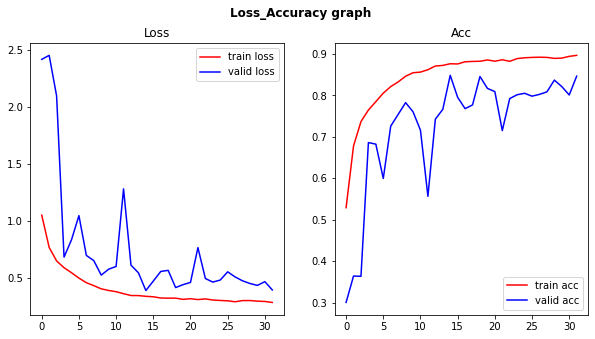

Start Train Epoch 32
Iter: 10/363, train epoch loss: 0.276276, train epoch acc: 0.900000, time: 19.006290
Iter: 20/363, train epoch loss: 0.268886, train epoch acc: 0.903125, time: 16.028839
Iter: 30/363, train epoch loss: 0.275750, train epoch acc: 0.899479, time: 15.446033
Iter: 40/363, train epoch loss: 0.270246, train epoch acc: 0.899219, time: 15.762238
Iter: 50/363, train epoch loss: 0.274964, train epoch acc: 0.900000, time: 15.723956
Iter: 60/363, train epoch loss: 0.272386, train epoch acc: 0.899219, time: 15.784987
Iter: 70/363, train epoch loss: 0.274438, train epoch acc: 0.896652, time: 15.844906
Iter: 80/363, train epoch loss: 0.269657, train epoch acc: 0.900586, time: 17.266722
Iter: 90/363, train epoch loss: 0.269095, train epoch acc: 0.900000, time: 15.891328
Iter: 100/363, train epoch loss: 0.267325, train epoch acc: 0.901719, time: 16.444271
Iter: 110/363, train epoch loss: 0.269427, train epoch acc: 0.901420, time: 15.878638
Iter: 120/363, train epoch loss: 0.274666,

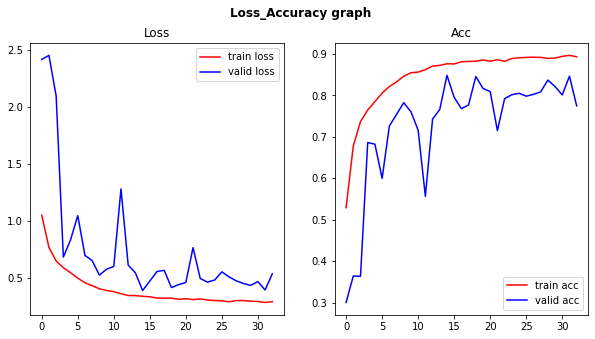

Start Train Epoch 33
Iter: 10/363, train epoch loss: 0.294848, train epoch acc: 0.906250, time: 17.032344
Iter: 20/363, train epoch loss: 0.278514, train epoch acc: 0.905469, time: 15.981379
Iter: 30/363, train epoch loss: 0.277198, train epoch acc: 0.904167, time: 16.162009
Iter: 40/363, train epoch loss: 0.280979, train epoch acc: 0.903125, time: 17.536263
Iter: 50/363, train epoch loss: 0.283365, train epoch acc: 0.899687, time: 17.156162
Iter: 60/363, train epoch loss: 0.279627, train epoch acc: 0.900521, time: 17.142499
Iter: 70/363, train epoch loss: 0.285219, train epoch acc: 0.898661, time: 16.268298
Iter: 80/363, train epoch loss: 0.285424, train epoch acc: 0.898828, time: 16.242067
Iter: 90/363, train epoch loss: 0.280709, train epoch acc: 0.901042, time: 15.784656
Iter: 100/363, train epoch loss: 0.277036, train epoch acc: 0.902813, time: 15.960310
Iter: 110/363, train epoch loss: 0.280707, train epoch acc: 0.900426, time: 15.847231
Iter: 120/363, train epoch loss: 0.280890,

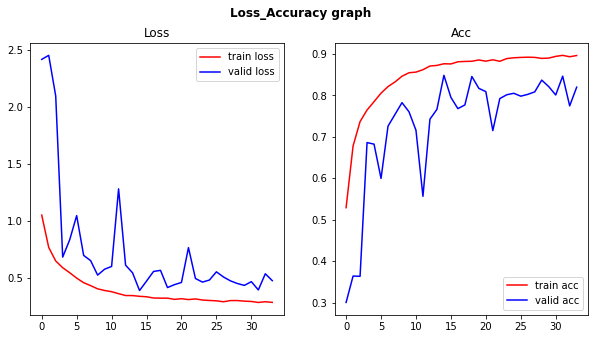

Start Train Epoch 34
Iter: 10/363, train epoch loss: 0.245779, train epoch acc: 0.915625, time: 16.945166
Iter: 20/363, train epoch loss: 0.254031, train epoch acc: 0.908594, time: 16.232933
Iter: 30/363, train epoch loss: 0.249163, train epoch acc: 0.912500, time: 17.757526
Iter: 40/363, train epoch loss: 0.260575, train epoch acc: 0.905078, time: 16.162343
Iter: 50/363, train epoch loss: 0.270027, train epoch acc: 0.899687, time: 16.345518
Iter: 60/363, train epoch loss: 0.274018, train epoch acc: 0.897917, time: 15.850159
Iter: 70/363, train epoch loss: 0.280625, train epoch acc: 0.896429, time: 16.221050
Iter: 80/363, train epoch loss: 0.282857, train epoch acc: 0.895508, time: 15.801438
Iter: 90/363, train epoch loss: 0.283557, train epoch acc: 0.894792, time: 18.076919
Iter: 100/363, train epoch loss: 0.278227, train epoch acc: 0.897500, time: 16.432766
Iter: 110/363, train epoch loss: 0.277324, train epoch acc: 0.897585, time: 16.123840
Iter: 120/363, train epoch loss: 0.275680,

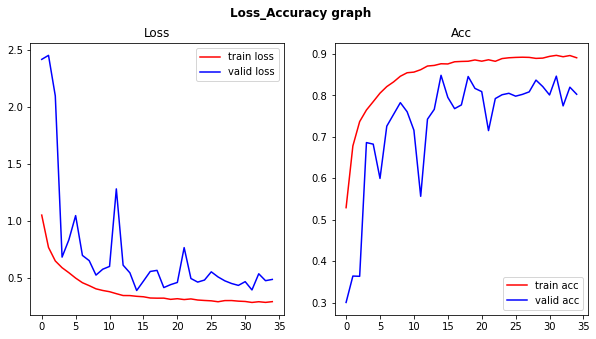

Start Train Epoch 35
Iter: 10/363, train epoch loss: 0.275418, train epoch acc: 0.893750, time: 18.241803
Iter: 20/363, train epoch loss: 0.294643, train epoch acc: 0.889844, time: 16.296846
Iter: 30/363, train epoch loss: 0.287268, train epoch acc: 0.892188, time: 15.915865
Iter: 40/363, train epoch loss: 0.281867, train epoch acc: 0.893750, time: 15.599280
Iter: 50/363, train epoch loss: 0.279665, train epoch acc: 0.896563, time: 15.641062
Iter: 60/363, train epoch loss: 0.277074, train epoch acc: 0.899219, time: 16.001468
Iter: 70/363, train epoch loss: 0.279148, train epoch acc: 0.896652, time: 15.452996
Iter: 80/363, train epoch loss: 0.279589, train epoch acc: 0.895508, time: 16.015039
Iter: 90/363, train epoch loss: 0.281297, train epoch acc: 0.894965, time: 15.909503
Iter: 100/363, train epoch loss: 0.282063, train epoch acc: 0.894687, time: 15.594364
Iter: 110/363, train epoch loss: 0.280642, train epoch acc: 0.895881, time: 16.267114
Iter: 120/363, train epoch loss: 0.281090,

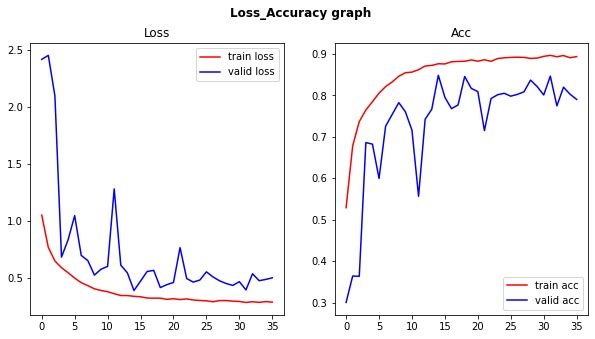

Start Train Epoch 36
Iter: 10/363, train epoch loss: 0.268752, train epoch acc: 0.903125, time: 17.709602
Iter: 20/363, train epoch loss: 0.264927, train epoch acc: 0.902344, time: 16.086454
Iter: 30/363, train epoch loss: 0.277618, train epoch acc: 0.892188, time: 15.874065
Iter: 40/363, train epoch loss: 0.280688, train epoch acc: 0.894141, time: 16.322556
Iter: 50/363, train epoch loss: 0.277658, train epoch acc: 0.896875, time: 17.294069
Iter: 60/363, train epoch loss: 0.272860, train epoch acc: 0.898698, time: 17.563471
Iter: 70/363, train epoch loss: 0.272869, train epoch acc: 0.898438, time: 17.160692
Iter: 80/363, train epoch loss: 0.275785, train epoch acc: 0.895508, time: 16.179744
Iter: 90/363, train epoch loss: 0.272624, train epoch acc: 0.898264, time: 16.265644
Iter: 100/363, train epoch loss: 0.272935, train epoch acc: 0.897344, time: 15.638373
Iter: 110/363, train epoch loss: 0.270356, train epoch acc: 0.899148, time: 15.569711
Iter: 120/363, train epoch loss: 0.271390,

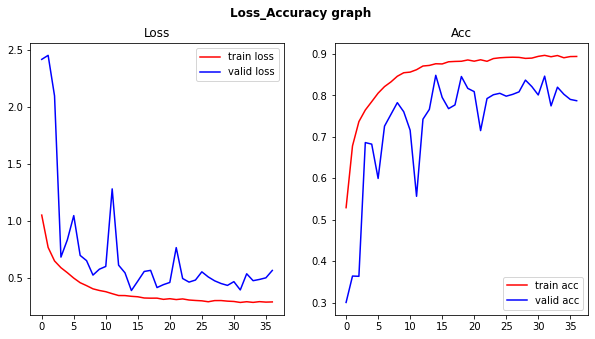

Start Train Epoch 37
Iter: 10/363, train epoch loss: 0.328914, train epoch acc: 0.878125, time: 18.150306
Iter: 20/363, train epoch loss: 0.310618, train epoch acc: 0.885156, time: 16.916625
Iter: 30/363, train epoch loss: 0.320550, train epoch acc: 0.875521, time: 17.645104
Iter: 40/363, train epoch loss: 0.324065, train epoch acc: 0.875781, time: 16.638736
Iter: 50/363, train epoch loss: 0.325207, train epoch acc: 0.875000, time: 15.731663
Iter: 60/363, train epoch loss: 0.328260, train epoch acc: 0.875781, time: 15.977862
Iter: 70/363, train epoch loss: 0.322021, train epoch acc: 0.878571, time: 16.533478
Iter: 80/363, train epoch loss: 0.315016, train epoch acc: 0.883008, time: 16.801941
Iter: 90/363, train epoch loss: 0.308358, train epoch acc: 0.885417, time: 15.568274
Iter: 100/363, train epoch loss: 0.305348, train epoch acc: 0.887344, time: 16.279565
Iter: 110/363, train epoch loss: 0.307385, train epoch acc: 0.886648, time: 15.980405
Iter: 120/363, train epoch loss: 0.307724,

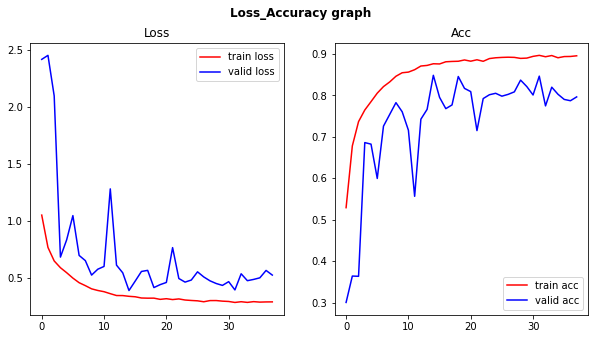

Start Train Epoch 38
Iter: 10/363, train epoch loss: 0.244874, train epoch acc: 0.917188, time: 1009.352154
Iter: 20/363, train epoch loss: 0.276782, train epoch acc: 0.905469, time: 19.291087
Iter: 30/363, train epoch loss: 0.286824, train epoch acc: 0.902083, time: 18.716050
Iter: 40/363, train epoch loss: 0.281144, train epoch acc: 0.900000, time: 16.106362
Iter: 50/363, train epoch loss: 0.281525, train epoch acc: 0.901250, time: 15.411753
Iter: 60/363, train epoch loss: 0.285780, train epoch acc: 0.898698, time: 921.846929
Iter: 70/363, train epoch loss: 0.286007, train epoch acc: 0.899107, time: 16.366298
Iter: 80/363, train epoch loss: 0.287822, train epoch acc: 0.897656, time: 17.204830
Iter: 90/363, train epoch loss: 0.287333, train epoch acc: 0.897222, time: 16.572188
Iter: 100/363, train epoch loss: 0.284094, train epoch acc: 0.899375, time: 936.119836
Iter: 110/363, train epoch loss: 0.286653, train epoch acc: 0.896875, time: 16.862111
Iter: 120/363, train epoch loss: 0.287

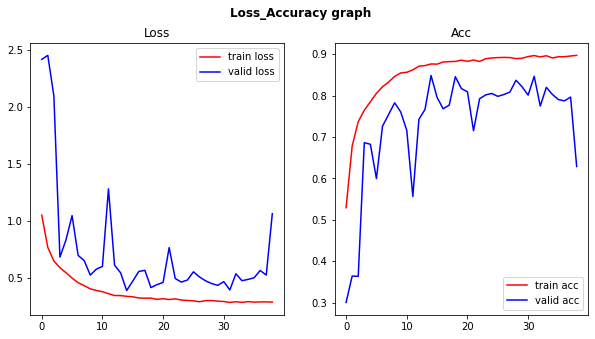

Start Train Epoch 39
Iter: 10/363, train epoch loss: 0.298377, train epoch acc: 0.892188, time: 16.434402
Iter: 20/363, train epoch loss: 0.280773, train epoch acc: 0.892188, time: 15.504984
Iter: 30/363, train epoch loss: 0.293144, train epoch acc: 0.892188, time: 14.997054
Iter: 40/363, train epoch loss: 0.295623, train epoch acc: 0.891797, time: 16.507464
Iter: 50/363, train epoch loss: 0.299200, train epoch acc: 0.892188, time: 15.898775
Iter: 60/363, train epoch loss: 0.298770, train epoch acc: 0.889844, time: 15.209052
Iter: 70/363, train epoch loss: 0.303126, train epoch acc: 0.886384, time: 15.039107
Iter: 80/363, train epoch loss: 0.296204, train epoch acc: 0.888867, time: 15.150032
Iter: 90/363, train epoch loss: 0.296534, train epoch acc: 0.889583, time: 14.888636
Iter: 100/363, train epoch loss: 0.296240, train epoch acc: 0.889687, time: 14.895801
Iter: 110/363, train epoch loss: 0.297038, train epoch acc: 0.889915, time: 15.001727
Iter: 120/363, train epoch loss: 0.295288,

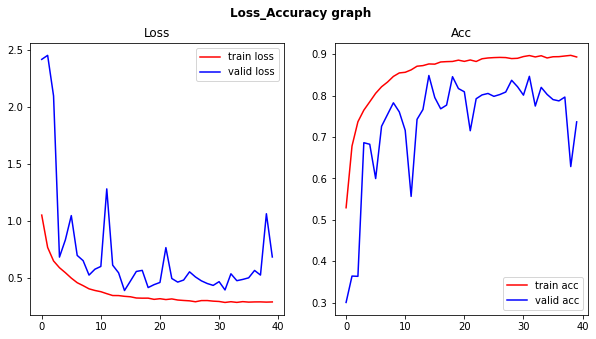

Start Train Epoch 40
Iter: 10/363, train epoch loss: 0.286643, train epoch acc: 0.892188, time: 16.122975
Iter: 20/363, train epoch loss: 0.287046, train epoch acc: 0.890625, time: 15.929344
Iter: 30/363, train epoch loss: 0.291844, train epoch acc: 0.888021, time: 15.105568
Iter: 40/363, train epoch loss: 0.287531, train epoch acc: 0.889062, time: 14.962682
Iter: 50/363, train epoch loss: 0.293596, train epoch acc: 0.885938, time: 15.015380
Iter: 60/363, train epoch loss: 0.290790, train epoch acc: 0.887760, time: 14.952735
Iter: 70/363, train epoch loss: 0.289826, train epoch acc: 0.889955, time: 14.930081
Iter: 80/363, train epoch loss: 0.290337, train epoch acc: 0.890820, time: 14.964939
Iter: 90/363, train epoch loss: 0.291322, train epoch acc: 0.890104, time: 15.051654
Iter: 100/363, train epoch loss: 0.292521, train epoch acc: 0.890156, time: 15.297055
Iter: 110/363, train epoch loss: 0.293322, train epoch acc: 0.888778, time: 15.966160
Iter: 120/363, train epoch loss: 0.291559,

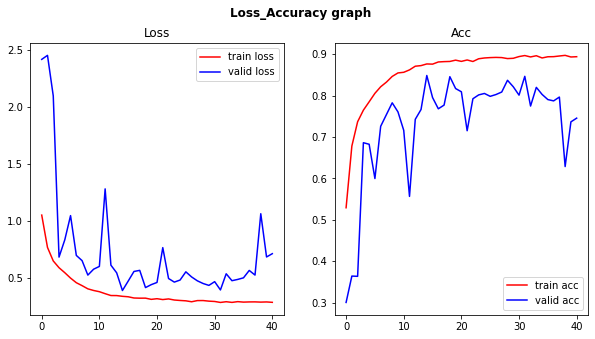

Start Train Epoch 41
Iter: 10/363, train epoch loss: 0.255872, train epoch acc: 0.900000, time: 15.932057
Iter: 20/363, train epoch loss: 0.259999, train epoch acc: 0.892188, time: 16.727216
Iter: 30/363, train epoch loss: 0.266501, train epoch acc: 0.896354, time: 15.044477
Iter: 40/363, train epoch loss: 0.269747, train epoch acc: 0.898438, time: 15.174126
Iter: 50/363, train epoch loss: 0.265459, train epoch acc: 0.902813, time: 15.085453
Iter: 60/363, train epoch loss: 0.261913, train epoch acc: 0.904427, time: 15.012142
Iter: 70/363, train epoch loss: 0.261880, train epoch acc: 0.904687, time: 14.969992
Iter: 80/363, train epoch loss: 0.263591, train epoch acc: 0.903516, time: 17.293557
Iter: 90/363, train epoch loss: 0.260231, train epoch acc: 0.905208, time: 15.244849
Iter: 100/363, train epoch loss: 0.262364, train epoch acc: 0.905000, time: 16.009418
Iter: 110/363, train epoch loss: 0.264164, train epoch acc: 0.904261, time: 14.905357
Iter: 120/363, train epoch loss: 0.263224,

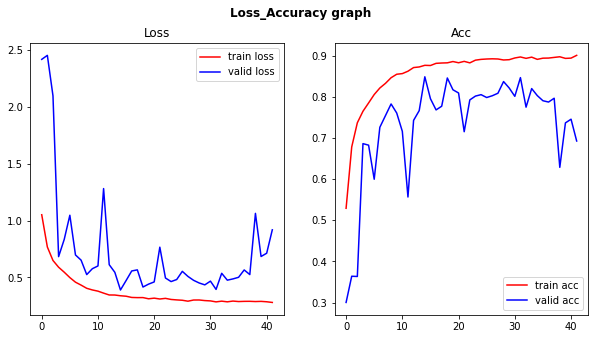

Start Train Epoch 42
Iter: 10/363, train epoch loss: 0.303988, train epoch acc: 0.909375, time: 18.675416
Iter: 20/363, train epoch loss: 0.300135, train epoch acc: 0.904687, time: 16.426222
Iter: 30/363, train epoch loss: 0.291036, train epoch acc: 0.903125, time: 16.563504
Iter: 40/363, train epoch loss: 0.277900, train epoch acc: 0.907422, time: 15.827318
Iter: 50/363, train epoch loss: 0.279867, train epoch acc: 0.906250, time: 14.998984
Iter: 60/363, train epoch loss: 0.280358, train epoch acc: 0.903906, time: 15.162984
Iter: 70/363, train epoch loss: 0.274304, train epoch acc: 0.907366, time: 15.183427
Iter: 80/363, train epoch loss: 0.272614, train epoch acc: 0.906445, time: 15.916804
Iter: 90/363, train epoch loss: 0.273191, train epoch acc: 0.906424, time: 16.001567
Iter: 100/363, train epoch loss: 0.270644, train epoch acc: 0.906250, time: 15.064746
Iter: 110/363, train epoch loss: 0.270731, train epoch acc: 0.906108, time: 15.015410
Iter: 120/363, train epoch loss: 0.272442,

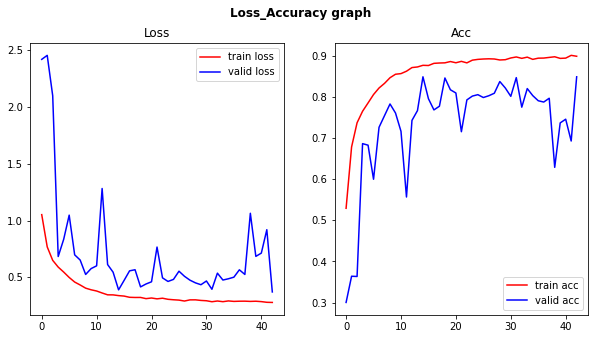

Start Train Epoch 43
Iter: 10/363, train epoch loss: 0.284515, train epoch acc: 0.884375, time: 16.172744
Iter: 20/363, train epoch loss: 0.300931, train epoch acc: 0.881250, time: 15.007360
Iter: 30/363, train epoch loss: 0.276265, train epoch acc: 0.893750, time: 14.983011
Iter: 40/363, train epoch loss: 0.281201, train epoch acc: 0.891797, time: 14.961945
Iter: 50/363, train epoch loss: 0.278619, train epoch acc: 0.896563, time: 14.919054
Iter: 60/363, train epoch loss: 0.275571, train epoch acc: 0.897135, time: 14.934049
Iter: 70/363, train epoch loss: 0.271024, train epoch acc: 0.900446, time: 14.933041
Iter: 80/363, train epoch loss: 0.273145, train epoch acc: 0.897070, time: 14.967369
Iter: 90/363, train epoch loss: 0.277221, train epoch acc: 0.895660, time: 14.774467
Iter: 100/363, train epoch loss: 0.276793, train epoch acc: 0.895938, time: 14.948083
Iter: 110/363, train epoch loss: 0.278805, train epoch acc: 0.895597, time: 14.953679
Iter: 120/363, train epoch loss: 0.279676,

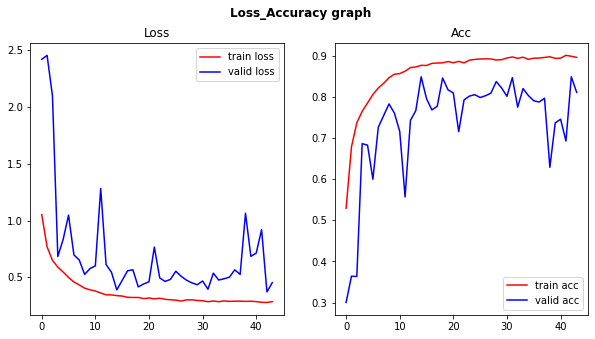

Start Train Epoch 44
Iter: 10/363, train epoch loss: 0.299686, train epoch acc: 0.885938, time: 17.705471
Iter: 20/363, train epoch loss: 0.288038, train epoch acc: 0.891406, time: 15.079007
Iter: 30/363, train epoch loss: 0.296053, train epoch acc: 0.890625, time: 14.995293
Iter: 40/363, train epoch loss: 0.288290, train epoch acc: 0.894531, time: 15.099384
Iter: 50/363, train epoch loss: 0.288702, train epoch acc: 0.896250, time: 14.926872
Iter: 60/363, train epoch loss: 0.285146, train epoch acc: 0.899479, time: 18.447515
Iter: 70/363, train epoch loss: 0.281866, train epoch acc: 0.898884, time: 15.367541
Iter: 80/363, train epoch loss: 0.287831, train epoch acc: 0.896094, time: 15.050837
Iter: 90/363, train epoch loss: 0.288332, train epoch acc: 0.895139, time: 14.891172
Iter: 100/363, train epoch loss: 0.287884, train epoch acc: 0.893594, time: 15.226368
Iter: 110/363, train epoch loss: 0.284690, train epoch acc: 0.895739, time: 20.113234
Iter: 120/363, train epoch loss: 0.284724,

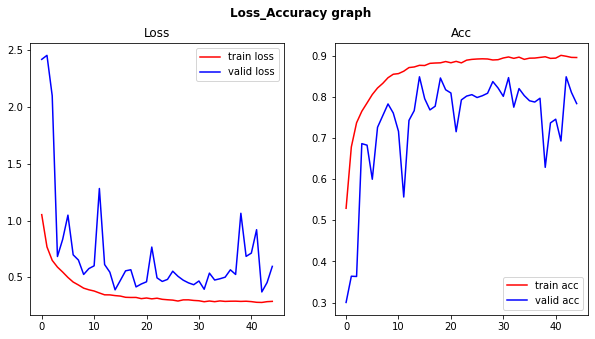

Start Train Epoch 45
Iter: 10/363, train epoch loss: 0.291629, train epoch acc: 0.893750, time: 17.559990
Iter: 20/363, train epoch loss: 0.273707, train epoch acc: 0.901563, time: 15.574436
Iter: 30/363, train epoch loss: 0.271317, train epoch acc: 0.902083, time: 15.387654
Iter: 40/363, train epoch loss: 0.271801, train epoch acc: 0.902344, time: 15.676322
Iter: 50/363, train epoch loss: 0.272588, train epoch acc: 0.899687, time: 15.670983
Iter: 60/363, train epoch loss: 0.275229, train epoch acc: 0.897917, time: 15.746248
Iter: 70/363, train epoch loss: 0.274603, train epoch acc: 0.897321, time: 15.831259
Iter: 80/363, train epoch loss: 0.272198, train epoch acc: 0.897070, time: 16.443294
Iter: 90/363, train epoch loss: 0.269260, train epoch acc: 0.898611, time: 16.899821
Iter: 100/363, train epoch loss: 0.271415, train epoch acc: 0.897969, time: 15.731192
Iter: 110/363, train epoch loss: 0.276008, train epoch acc: 0.895881, time: 15.673618
Iter: 120/363, train epoch loss: 0.276784,

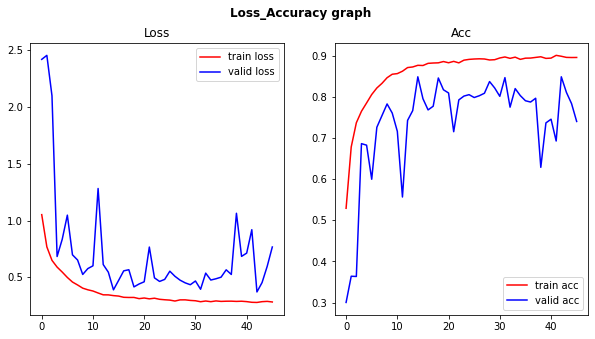

Start Train Epoch 46
Iter: 10/363, train epoch loss: 0.305585, train epoch acc: 0.884375, time: 16.692526
Iter: 20/363, train epoch loss: 0.289457, train epoch acc: 0.895312, time: 16.248667
Iter: 30/363, train epoch loss: 0.289019, train epoch acc: 0.898958, time: 18.543927
Iter: 40/363, train epoch loss: 0.278412, train epoch acc: 0.900781, time: 15.617877
Iter: 50/363, train epoch loss: 0.272196, train epoch acc: 0.902188, time: 16.964588
Iter: 60/363, train epoch loss: 0.266108, train epoch acc: 0.903646, time: 16.203277
Iter: 70/363, train epoch loss: 0.266355, train epoch acc: 0.903571, time: 16.389270
Iter: 80/363, train epoch loss: 0.273192, train epoch acc: 0.901172, time: 16.337068
Iter: 90/363, train epoch loss: 0.273207, train epoch acc: 0.901389, time: 16.043638
Iter: 100/363, train epoch loss: 0.269909, train epoch acc: 0.902344, time: 16.584134
Iter: 110/363, train epoch loss: 0.268708, train epoch acc: 0.902983, time: 15.616245
Iter: 120/363, train epoch loss: 0.266896,

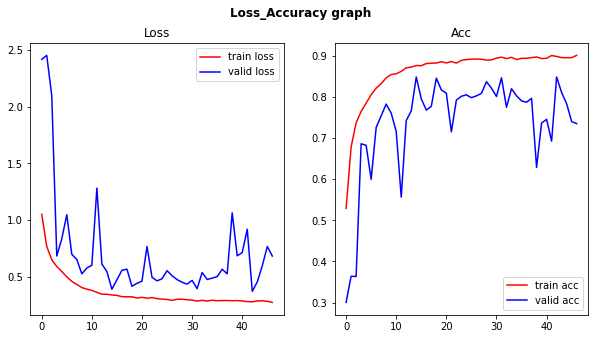

Start Train Epoch 47
Iter: 10/363, train epoch loss: 0.280578, train epoch acc: 0.885938, time: 17.350620
Iter: 20/363, train epoch loss: 0.285720, train epoch acc: 0.889062, time: 16.370087
Iter: 30/363, train epoch loss: 0.286983, train epoch acc: 0.892188, time: 15.532120
Iter: 40/363, train epoch loss: 0.285210, train epoch acc: 0.891797, time: 16.675689
Iter: 50/363, train epoch loss: 0.282098, train epoch acc: 0.894062, time: 16.158182
Iter: 60/363, train epoch loss: 0.279760, train epoch acc: 0.896094, time: 15.780556
Iter: 70/363, train epoch loss: 0.278145, train epoch acc: 0.897991, time: 16.454772
Iter: 80/363, train epoch loss: 0.279319, train epoch acc: 0.895898, time: 17.858308
Iter: 90/363, train epoch loss: 0.277035, train epoch acc: 0.896701, time: 16.477477
Iter: 100/363, train epoch loss: 0.279717, train epoch acc: 0.896875, time: 16.001230
Iter: 110/363, train epoch loss: 0.277732, train epoch acc: 0.896875, time: 16.279085
Iter: 120/363, train epoch loss: 0.279284,

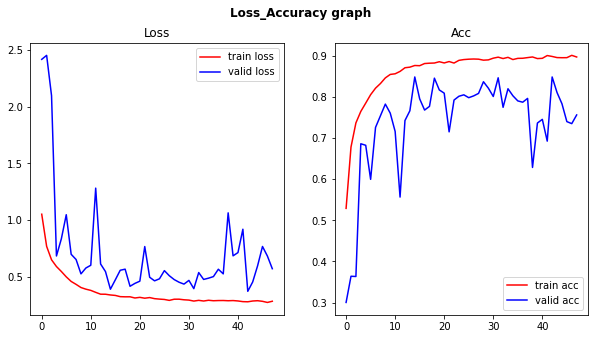

Start Train Epoch 48
Iter: 10/363, train epoch loss: 0.281475, train epoch acc: 0.890625, time: 18.120110
Iter: 20/363, train epoch loss: 0.256079, train epoch acc: 0.900781, time: 16.408205
Iter: 30/363, train epoch loss: 0.254338, train epoch acc: 0.902604, time: 17.210965
Iter: 40/363, train epoch loss: 0.261903, train epoch acc: 0.902344, time: 15.770611
Iter: 50/363, train epoch loss: 0.270809, train epoch acc: 0.900312, time: 16.445531
Iter: 60/363, train epoch loss: 0.275500, train epoch acc: 0.897135, time: 15.999631
Iter: 70/363, train epoch loss: 0.276232, train epoch acc: 0.896429, time: 15.802736
Iter: 80/363, train epoch loss: 0.278870, train epoch acc: 0.894727, time: 15.691080
Iter: 90/363, train epoch loss: 0.276274, train epoch acc: 0.896007, time: 16.140790
Iter: 100/363, train epoch loss: 0.272693, train epoch acc: 0.898750, time: 15.636263
Iter: 110/363, train epoch loss: 0.270018, train epoch acc: 0.900284, time: 19.483398
Iter: 120/363, train epoch loss: 0.268971,

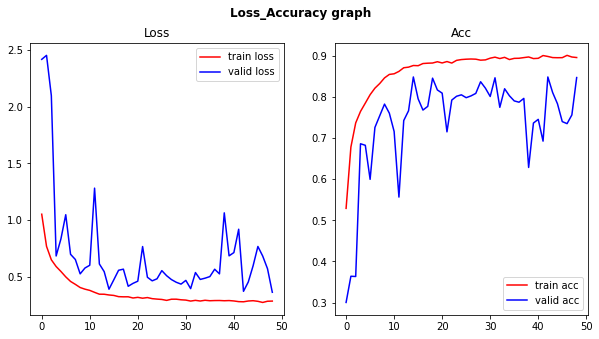

Start Train Epoch 49
Iter: 10/363, train epoch loss: 0.294799, train epoch acc: 0.896875, time: 17.521127
Iter: 20/363, train epoch loss: 0.275136, train epoch acc: 0.901563, time: 17.598953
Iter: 30/363, train epoch loss: 0.279863, train epoch acc: 0.895833, time: 18.033023
Iter: 40/363, train epoch loss: 0.275587, train epoch acc: 0.899219, time: 17.567313
Iter: 50/363, train epoch loss: 0.277821, train epoch acc: 0.899062, time: 16.501012
Iter: 60/363, train epoch loss: 0.279408, train epoch acc: 0.898177, time: 15.828304
Iter: 70/363, train epoch loss: 0.272207, train epoch acc: 0.901786, time: 16.276367
Iter: 80/363, train epoch loss: 0.273386, train epoch acc: 0.898438, time: 15.978633
Iter: 90/363, train epoch loss: 0.271870, train epoch acc: 0.899306, time: 16.553059
Iter: 100/363, train epoch loss: 0.268938, train epoch acc: 0.900000, time: 15.900486
Iter: 110/363, train epoch loss: 0.267874, train epoch acc: 0.899574, time: 16.037797
Iter: 120/363, train epoch loss: 0.269749,

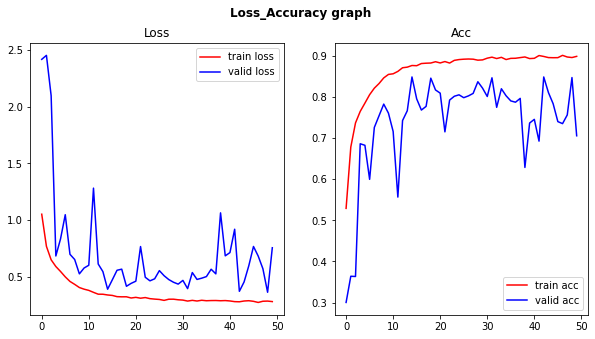

Training time : 34890.180030


In [16]:
device = "mps"
find_drowsy = mini_Xception(n_class=4)
trainer = Drive_Trainer(model=find_drowsy, opt='adam', lr=0.001, has_scheduler=False, device=device).to(device)
start_time = time.time()
trainer.train(train_loader, valid_loader, max_epoch=50, disp_epoch=1, check_point=True)
print(f"Training time : {time.time()-start_time:>3f}")